
<font color="steelblue" size="3" face="微软雅黑">
<h1>HS300+</h1>
<p>寻找沪深300指数的拐点信号</p>
</font>

In [2]:
# xtquant
from xtquant import xtdata
from xtquant.xttrader import XtQuantTrader
from xtquant import xtconstant
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount

# self defined
import backtest as bt
from backtest import Context 

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
# system
import datetime
import time
import logging
import random


# 函数定义

In [4]:
# 获取股票历史交易数据
def get_hist_data(start_date_str, end_date_str, code_list, count, dividend_type='none', period='1d', fields=['open', 'close', 'high', 'low', 'volume', 'amount', 'preClose']):
    xtdata.download_history_data2(code_list, period, start_date_str, end_date_str)
    
    ret = xtdata.get_market_data_ex(field_list=fields,
                                    stock_list=code_list,
                                    period=period,
                                    start_time='',
                                    end_time=end_date_str,
                                    count=count,
                                    dividend_type=dividend_type
            )
    return ret

# 取消订单
def cancel_untraded_order(acc):
    cancelable_order_list = xt_trader.query_stock_orders(acc, cancelable_only = True)
    for cancelable_order in cancelable_order_list:
        cur_time = datetime.datetime.now().timestamp()
        print(cur_time)
        order_time = cancelable_order.order_time
        print(order_time)
        if cur_time - order_time >= 300:
            cancel_result = xt_trader.cancel_order_stock_async(acc, cancelable_order.order_id)

# 获取持仓信息
def get_hold_position():
    # get hold position
    positions = xt_trader.query_stock_positions(account)
    #print("positions:", len(positions))
    #if len(positions) != 0:
    #    print("last position:", positions[-1])
        
    stock_list = []
    position_dict = {}
    for i in range(len(positions)):
        #print("{0} {1} {2} {3} {4} {5}".format(positions[i].account_id, 
        #                           positions[i].stock_code, 
        #                           positions[i].volume, 
        #                           positions[i].open_price, 
        #                           positions[i].market_value, 
        #                           positions[i].avg_price))
        position = {
            "stock_code": positions[i].stock_code, 
            "volume": positions[i].volume, 
            "can_use_volume": positions[i].can_use_volume, 
            "open_price": positions[i].open_price, 
            "market_value": positions[i].market_value, 
            "avg_price": positions[i].avg_price
        }
        stock_list.append(positions[i].stock_code)
        position_dict[positions[i].stock_code] = position
    return stock_list, position_dict

***<font color=steel
    size=5
       face=雅黑>
<mark>xquant trader connect</mark>
</font>***

In [8]:
current_date = datetime.datetime.now()
c_date_str = current_date.strftime("%Y%m%d")
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s', filename = c_date_str + '.txt')

In [10]:
class MyXtQuantTraderCallback(XtQuantTraderCallback):
    import logging
    current_date = datetime.datetime.now()
    c_date_str = current_date.strftime("%Y%m%d")
    logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s', filename = c_date_str + '.txt')
    def on_disconnected(self):
        """
        连接断开
        :return:
        """
        print(datetime.datetime.now(),'连接断开回调')
        connect_result, account = trader_connect()
        while connect_result != 0:
            connect_result = trader_connect()

    def on_stock_order(self, order):
        """
        委托回报推送
        :param order: XtOrder对象
        :return:
        """
        print(datetime.datetime.now(), '委托回调', order.order_remark)
        logging.info('on_stock_order')


    def on_stock_trade(self, trade):
        """
        成交变动推送
        :param trade: XtTrade对象
        :return:
        """
        print(datetime.datetime.now(), '成交回调', trade.order_remark)
        logging.info('on_stock_trade')


    def on_order_error(self, order_error):
        """
        委托失败推送
        :param order_error:XtOrderError 对象
        :return:
        """
        # print("on order_error callback")
        # print(order_error.order_id, order_error.error_id, order_error.error_msg)
        print(f"委托报错回调 {order_error.order_remark} {order_error.error_msg}")
        logging.info('on_order_error')

    def on_cancel_error(self, cancel_error):
        """
        撤单失败推送
        :param cancel_error: XtCancelError 对象
        :return:
        """
        print(datetime.datetime.now(), sys._getframe().f_code.co_name)

    def on_order_stock_async_response(self, response):
        """
        异步下单回报推送
        :param response: XtOrderResponse 对象
        :return:
        """
        print(f"异步委托回调 {response.order_remark}")
        logging.info('on_order_stock_async_response')

    def on_cancel_order_stock_async_response(self, response):
        """
        :param response: XtCancelOrderResponse 对象
        :return:
        """
        print(datetime.datetime.now(), sys._getframe().f_code.co_name)

    def on_account_status(self, status):
        """
        :param response: XtAccountStatus 对象
        :return:
        """
        print(datetime.datetime.now(), sys._getframe().f_code.co_name)

In [12]:
if __name__ == '__main__':
    print("start")
    #指定客户端所在路径
    path = r'D:\国金QMT交易端模拟\bin.x64/../userdata_mini'
    # 生成session id 整数类型 同时运行的策略不能重复
    session_id = int(time.time())
    xt_trader = XtQuantTrader(path, session_id)
    # 开启主动请求接口的专用线程 开启后在on_stock_xxx回调函数里调用XtQuantTrader.query_xxx函数不会卡住回调线程，但是查询和推送的数据在时序上会变得不确定
    # 详见: http://docs.thinktrader.net/vip/pages/ee0e9b/#开启主动请求接口的专用线程
    # xt_trader.set_relaxed_response_order_enabled(True)

    # 创建资金账号为 800068 的证券账号对象
    account = StockAccount('55004948', 'STOCK')
    # 创建交易回调类对象，并声明接收回调
    callback = MyXtQuantTraderCallback()
    xt_trader.register_callback(callback)
    # 启动交易线程
    xt_trader.start()
    # 建立交易连接，返回0表示连接成功
    connect_result = xt_trader.connect()
    print('建立交易连接，返回0表示连接成功', connect_result)
    # 对交易回调进行订阅，订阅后可以收到交易主推，返回0表示订阅成功
    subscribe_result = xt_trader.subscribe(account)
    print('对交易回调进行订阅，订阅后可以收到交易主推，返回0表示订阅成功', subscribe_result)

    #这一行是注册全推回调函数 包括下单判断 安全起见处于注释状态 确认理解效果后再放开
    # xtdata.subscribe_whole_quote(["SH", "SZ"], callback=f)
    # 阻塞主线程退出
    #xt_trader.run_forever()
    # 如果使用vscode pycharm等本地编辑器 可以进入交互模式 方便调试 （把上一行的run_forever注释掉 否则不会执行到这里）
    #interact()

start
建立交易连接，返回0表示连接成功 0
对交易回调进行订阅，订阅后可以收到交易主推，返回0表示订阅成功 0


In [14]:
#connect_result, account, xt_trader = trader_connect()

***<font color=steel
    size=5
       face=雅黑>
<mark>获取目标股票池</mark>
</font>***

In [17]:
#xtdata.download_sector_data()
#sectors = xtdata.get_sector_list()
sector_list = ['创业板', '沪深A股', '沪深ETF', '科创板',
               'ETF主题指数', 'ETF债券型', 'ETF商品型', 
               'ETF股票型', 'ETF行业指数', 'ETF货币型', 'ETF跨境型']
sector_list = ['沪深300']
res = {}
for sector in sector_list:
    stock_list = xtdata.get_stock_list_in_sector(sector)
    for stock in stock_list:
        res[stock] = 1

***** xtdata连接成功 *****
服务信息: {'tag': 'sp3', 'version': '1.0'}
服务地址: 127.0.0.1:58610
数据路径: D:\国金QMT交易端模拟\bin.x64/../userdata_mini/datadir
设置xtdata.enable_hello = False可隐藏此消息



***<font color=steel
    size=5
       face=雅黑>
<mark>连续多日交易量特征</mark>
</font>***

In [185]:
# datetime formatting
end_date = datetime.datetime.now() + datetime.timedelta(days=1)
end_date_str = end_date.strftime("%Y%m%d")

start_date = end_date - datetime.timedelta(days=60)
start_date_str = start_date.strftime("%Y%m%d")

current_date = datetime.datetime.now()
current_date_str = current_date.strftime("%Y%m%d")

ret = pd.DataFrame()

#获取目标股票池的交易数据
code_list = list(res.keys())
code_list.append('510310.SH')

hist_data_total = get_hist_data(start_date_str, end_date_str, code_list, 31)


# 遍历交易数据并进行特征加工

In [15]:
count = 0
for key in hist_data_total.keys():
    count += 1
    if count % 100 == 0:
        print(datetime.datetime.now(), ': ', count)
    code = key.split('.')[0]

    market = key.split('.')[1]

    hist_data = hist_data_total[key]
   
    if hist_data.shape[0] < 16:
        continue
        
    stat = hist_data.iloc[-1].to_dict()

    # 针对volume进行特征加工
    va1 = hist_data['volume'].iloc[-2]
    stat['va1'] = va1
    
    va2 = hist_data['volume'].iloc[-3]
    stat['va2'] = va2

    va2_6 = hist_data['volume'][-7:-2].mean()
    stat['va2_6'] = va2_6

    va3_7 = hist_data['volume'][-8:-3].mean()
    stat['va3_7'] = va3_7
    
    va1_5 = hist_data['volume'][-6:-1].mean()
    stat['va1_5'] = va1_5

    va5_10 = hist_data['volume'][-11:-6].mean()
    stat['va5_10'] = va5_10
    
    va5_15 = hist_data['volume'][-16:-6].mean()
    stat['va5_15'] = va5_15

    # 针对amount进行特征加工
    amo1 = hist_data['amount'].iloc[-2]
    stat['amo1'] = amo1

    amo2 = hist_data['amount'].iloc[-3]
    stat['amo2'] = amo2

    amo2_6 = hist_data['amount'][-7:-2].mean()
    stat['amo2_6'] = amo2_6

    amo3_7 = hist_data['amount'][-8:-3].mean()
    stat['amo3_7'] = amo3_7

    amo1_5 = hist_data['amount'][-6:-1].mean()
    stat['amo1_5'] = amo1_5

    amo5_10 = hist_data['amount'][-11:-6].mean()
    stat['amo5_10'] = amo5_10

    amo5_15 = hist_data['amount'][-16:-6].mean()
    stat['amo5_15'] = amo5_15
    
    df = pd.DataFrame(data=stat, index=[key])
    
    ret = pd.concat([df, ret])

2025-05-14 20:05:52.968777 :  100
2025-05-14 20:05:53.169681 :  200
2025-05-14 20:05:53.355045 :  300


# Calculate statistic features

In [17]:
ret['va1_5_va5_10'] = ret['va1_5'] / ret['va5_10']
ret['va1_5_va5_15'] = ret['va1_5'] / ret['va5_15']
ret['va0_va1_5'] = ret['volume'] / ret['va1_5']
ret['va1_va2_6'] = ret['va1'] / ret['va2_6']
ret['va2_va3_7'] = ret['va2'] / ret['va3_7']
ret['amo1_5_amo5_10'] = ret['amo1_5'] / ret['amo5_10']
ret['amo1_5_amo5_15'] = ret['amo1_5'] / ret['amo5_15']
ret['amo0_amo1_5'] = ret['amount'] / ret['amo1_5']
ret['amo1_amo2_6'] = ret['amo1'] / ret['amo2_6']
ret['amo2_amo3_7'] = ret['amo2'] / ret['amo3_7']


# 基本面特征

In [187]:
def get_inst_detail(code):
    return xtdata.get_instrument_detail(code)

ret['inst_detail'] = ret.index.map(get_inst_detail)
ret.to_csv('inst_detail.csv', index=False)
ret = ret.dropna()
ret['inst_name'] = ret['inst_detail'].apply(lambda x: x['InstrumentName'])
# remove ST instrument
ret = ret[ret['inst_detail'].apply(lambda x: 'ST' not in x['InstrumentName'])]
# remove non-ETF instrument which is less than 1 dollar
ret = ret[(
    (ret['inst_detail'].apply(lambda x: 'ETF' not in x['InstrumentName'])) & (ret['close'] > 1)
) | (ret['inst_detail'].apply(lambda x: 'ETF' in x['InstrumentName']))]


KeyError: 'inst_detail'

In [20]:
#get_inst_detail('301269.SZ')
#ret['inst_name']
ret.head(10)
#ret['inst_name'] = ret['inst_detail'].apply(lambda x: x['InstrumentName'])
ret['inst_detail'].apply(lambda x: x['InstrumentName'])

301269.SZ    华大九天
300999.SZ     金龙鱼
300979.SZ    华利集团
300896.SZ     爱美客
300832.SZ     新产业
             ... 
600015.SH    华夏银行
600011.SH    华能国际
600010.SH    包钢股份
600009.SH    上海机场
600000.SH    浦发银行
Name: inst_detail, Length: 299, dtype: object

In [34]:
ret.sort_values(
    ['va0_va1_5', 'va1_5', 'va1_5_va5_10'], ascending=False
)[['va0_va1_5', 'va1_5', 'va1_5_va5_10', 'inst_name', 'inst_detail']].head(10)


,va0_va1_5,va1_5,va1_5_va5_10,inst_name,inst_detail
601236.SH,7.096381,158541.8,1.128852,红塔证券,"{'ExchangeID': 'SH', 'InstrumentID': '601236',..."
000776.SZ,5.293890,367079.8,1.342022,广发证券,"{'ExchangeID': 'SZ', 'InstrumentID': '000776',..."
601628.SH,4.394626,96456.0,1.074278,中国人寿,"{'ExchangeID': 'SH', 'InstrumentID': '601628',..."
601319.SH,4.140609,593966.0,1.141253,中国人保,"{'ExchangeID': 'SH', 'InstrumentID': '601319',..."
601318.SH,3.335948,472798.2,1.185456,中国平安,"{'ExchangeID': 'SH', 'InstrumentID': '601318',..."
600026.SH,3.084589,267062.2,0.789787,中远海能,"{'ExchangeID': 'SH', 'InstrumentID': '600026',..."
600030.SH,2.978564,919589.4,1.581736,中信证券,"{'ExchangeID': 'SH', 'InstrumentID': '600030',..."
601601.SH,2.930598,328226.2,1.169187,中国太保,"{'ExchangeID': 'SH', 'InstrumentID': '601601',..."
601336.SH,2.826716,168510.4,1.016319,新华保险,"{'ExchangeID': 'SH', 'InstrumentID': '601336',..."
601919.SH,2.690167,1078686.6,1.718053,中远海控,"{'ExchangeID': 'SH', 'InstrumentID': '601919',..."


In [35]:
ret.sort_values(
    ['va0_va1_5', 'va1_5','va1_5_va5_10'], ascending=False
)[['va0_va1_5', 'va1_5','va1_5_va5_10', 'inst_name', 'inst_detail']].tail(10)

,va0_va1_5,va1_5,va1_5_va5_10,inst_name,inst_detail
000786.SZ,0.533813,136750.2,1.092701,北新建材,"{'ExchangeID': 'SZ', 'InstrumentID': '000786',..."
000661.SZ,0.533429,69379.4,0.908443,长春高新,"{'ExchangeID': 'SZ', 'InstrumentID': '000661',..."
600482.SH,0.517131,218575.0,1.406524,中国动力,"{'ExchangeID': 'SH', 'InstrumentID': '600482',..."
601989.SH,0.512028,2622213.2,4.157174,中国重工,"{'ExchangeID': 'SH', 'InstrumentID': '601989',..."
000338.SZ,0.501395,571535.2,1.604554,潍柴动力,"{'ExchangeID': 'SZ', 'InstrumentID': '000338',..."
002028.SZ,0.473745,57615.4,1.125560,思源电气,"{'ExchangeID': 'SZ', 'InstrumentID': '002028',..."
600372.SH,0.461126,644294.8,3.912965,中航机载,"{'ExchangeID': 'SH', 'InstrumentID': '600372',..."
600760.SH,0.458070,782862.8,6.165828,中航沈飞,"{'ExchangeID': 'SH', 'InstrumentID': '600760',..."
000768.SZ,0.454698,626007.4,4.920111,中航西飞,"{'ExchangeID': 'SZ', 'InstrumentID': '000768',..."
600893.SH,0.432615,419019.6,3.199590,航发动力,"{'ExchangeID': 'SH', 'InstrumentID': '600893',..."


In [36]:
hist_data_total['600760.SH']

,open,high,low,close,volume,amount,preClose
20250327,43.93,43.99,43.34,43.60,100350,4.377469e+08,43.93
20250328,43.60,43.67,43.03,43.42,130912,5.661025e+08,43.60
20250331,42.91,43.13,42.26,42.28,169522,7.207710e+08,43.42
20250401,43.68,45.13,43.68,44.49,496411,2.209200e+09,42.28
20250402,44.49,44.49,42.73,42.90,365893,1.583102e+09,44.49
20250403,42.68,43.16,42.53,42.94,136320,5.848606e+08,42.90
20250407,41.68,42.63,39.06,41.24,346522,1.428184e+09,42.94
20250408,41.22,42.00,41.13,42.00,220872,9.174035e+08,41.24
20250409,41.91,44.81,41.66,44.27,457739,2.008231e+09,42.00
20250410,44.26,45.10,43.57,44.60,345152,1.534035e+09,44.27


In [189]:
count = 0
ret = pd.DataFrame()
for key in hist_data_total.keys():
    count += 1
    if count % 100 == 0:
        print(datetime.datetime.now(), ': ', count)
    code = key.split('.')[0]

    market = key.split('.')[1]

    hist_data = hist_data_total[key]
   
    stat = hist_data.iloc[-1].to_dict()
    stat['week_preClose'] = hist_data.iloc[-8]['preClose']
    stat['month_preClose'] = hist_data.iloc[-31]['preClose']
    df = pd.DataFrame(data=stat, index=[key])
    ret = pd.concat([df, ret])

2025-05-14 21:03:45.656792 :  100
2025-05-14 21:03:45.749545 :  200
2025-05-14 21:03:45.867628 :  300


In [191]:
ret['week_return'] = ret['close'] / ret['week_preClose']
ret['month_return'] = ret['close'] / ret['month_preClose']

In [193]:
ret.sort_values(
    ['week_return','month_return'], ascending=False
)[['week_return','month_return']].tail(10)

,week_return,month_return
600066.SH,0.964151,0.979302
600489.SH,0.962777,0.997035
600547.SH,0.961576,1.127889
002371.SZ,0.961533,1.021747
688041.SH,0.960826,1.022474
000895.SZ,0.950499,0.945781
002555.SZ,0.937811,0.989501
300661.SZ,0.929764,1.120879
688506.SH,0.914266,1.276423
600837.SH,NaN,NaN


In [205]:
ret.sort_values(
    ['month_return'], ascending=False
)[['month_return']].tail(30)

,month_return
601699.SH,0.892380
300408.SZ,0.891493
300759.SZ,0.887260
600989.SH,0.886493
300628.SZ,0.886073
601600.SH,0.881510
603806.SH,0.876190
300394.SZ,0.875344
300413.SZ,0.874953
688036.SH,0.869071


In [201]:
ret.loc['510310.SH']

open              3.818000e+00
high              3.885000e+00
low               3.815000e+00
close             3.865000e+00
volume            3.546397e+06
amount            1.363713e+09
preClose          3.819000e+00
week_preClose     3.696000e+00
month_preClose    3.855000e+00
week_return       1.045725e+00
month_return      1.002594e+00
Name: 510310.SH, dtype: float64

In [228]:
ret[(ret['month_return'] > 0.9) & (ret['month_return'] < 0.95)].sort_values(
    ['month_return'], ascending=False
)[['month_return']].head(30)

,month_return
600089.SH,0.948535
600161.SH,0.948438
002463.SZ,0.947305
000895.SZ,0.945781
600570.SH,0.944828
600019.SH,0.942204
601878.SH,0.941076
000938.SZ,0.941046
601618.SH,0.937888
601059.SH,0.937387


In [226]:
hist_data_total['510310.SH']

,open,high,low,close,volume,amount,preClose
20250327,3.852,3.892,3.839,3.869,2771168,1.071505e+09,3.855
20250328,3.866,3.871,3.842,3.851,2385052,9.193776e+08,3.869
20250331,3.848,3.865,3.810,3.827,2285704,8.763110e+08,3.851
20250401,3.830,3.844,3.819,3.824,1915736,7.331937e+08,3.827
20250402,3.824,3.839,3.815,3.821,1267482,4.849733e+08,3.824
20250403,3.787,3.823,3.780,3.801,4036599,1.534164e+09,3.821
20250407,3.610,3.695,3.456,3.503,30298823,1.076155e+10,3.801
20250408,3.524,3.592,3.518,3.582,40373493,1.436353e+10,3.503
20250409,3.553,3.629,3.531,3.621,6663176,2.385294e+09,3.582
20250410,3.669,3.696,3.650,3.676,3680696,1.352864e+09,3.621


In [20]:
# coding=utf-8
from xtquant import xtdata
# 下载权重相关信息
xtdata.download_index_weight()
# 获取权重相关信息
ret_weight_data = xtdata.get_index_weight('000300.SH')
print(ret_weight_data)


{'000001.SZ': 0.534, '000002.SZ': 0.234, '000063.SZ': 0.52, '000100.SZ': 0.393, '000157.SZ': 0.184, '000166.SZ': 0.215, '000301.SZ': 0.117, '000333.SZ': 1.817, '000338.SZ': 0.416, '000408.SZ': 0.144, '000425.SZ': 0.368, '000538.SZ': 0.258, '000568.SZ': 0.46, '000596.SZ': 0.136, '000617.SZ': 0.088, '000625.SZ': 0.307, '000630.SZ': 0.122, '000651.SZ': 1.031, '000661.SZ': 0.143, '000708.SZ': 0.06, '000725.SZ': 0.716, '000768.SZ': 0.163, '000776.SZ': 0.233, '000786.SZ': 0.143, '000792.SZ': 0.307, '000800.SZ': 0.036, '000807.SZ': 0.16, '000858.SZ': 1.261, '000876.SZ': 0.11, '000895.SZ': 0.131, '000938.SZ': 0.29, '000963.SZ': 0.172, '000975.SZ': 0.17, '000977.SZ': 0.265, '000983.SZ': 0.092, '000999.SZ': 0.107, '001289.SZ': 0.013, '001965.SZ': 0.133, '001979.SZ': 0.167, '002001.SZ': 0.173, '002007.SZ': 0.091, '002027.SZ': 0.368, '002028.SZ': 0.225, '002049.SZ': 0.22, '002050.SZ': 0.303, '002074.SZ': 0.113, '002129.SZ': 0.125, '002142.SZ': 0.398, '002179.SZ': 0.261, '002180.SZ': 0.11, '002230.

In [21]:
# coding=utf-8
from xtquant import xtdata
stock_code = '000300.SH'
# 订阅指定合约最新行情
stat_time_str = '20050101'
end_time_str = '20250519'
xtdata.subscribe_quote(stock_code, period='1d', start_time=stat_time_str, end_time=end_time_str, count=0, callback=None)
# 下载指定合约历史行情
period='1d'
xtdata.download_history_data(stock_code, period, start_time=stat_time_str, end_time=end_time_str)
# 获取指定合约历史行情
ret = xtdata.get_market_data_ex(field_list = [], stock_list = [stock_code], period = '1d', start_time = stat_time_str, end_time = end_time_str, count = -1, dividend_type = 'none', fill_data = True)


<Axes: >

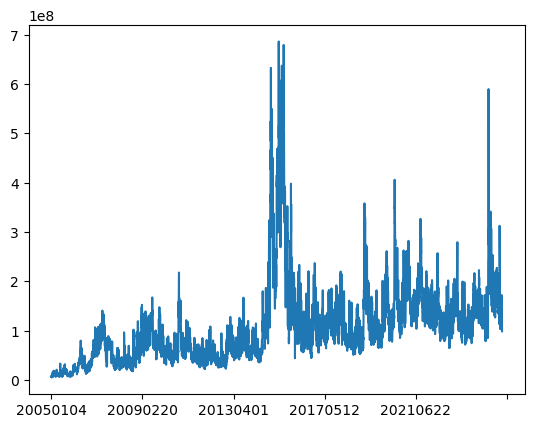

In [22]:
df = ret['000300.SH']
df['volume'].plot()

In [23]:
#df.datetime	open	high	low	close	volume	openinterest	code

#df.to_csv('HS300.csv')
df_tocsv = df.reset_index()
df_tocsv.columns
df_tocsv = df_tocsv[['index','open','high','low','close','volume','openInterest']]
df_tocsv.columns = ['datetime','open','high','low','close','volume','openinterest']
df_tocsv.head()
df_tocsv.to_csv('HS300.csv', index=False)

# 添加夜盘数据

In [28]:
df.head(10)

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag
20050104,1104768000000,994.77,994.77,980.66,982.79,7412869,4.431980e+09,0.0,0,1000.00,0
20050105,1104854400000,981.58,997.32,979.88,992.56,7119109,4.529210e+09,0.0,0,982.79,0
20050106,1104940800000,993.33,993.79,980.33,983.17,6288029,3.921020e+09,0.0,0,992.56,0
20050107,1105027200000,983.05,995.71,979.81,983.96,7298694,4.737470e+09,0.0,0,983.17,0
20050110,1105286400000,983.76,993.96,979.79,993.88,5791698,3.762930e+09,0.0,0,983.96,0
20050111,1105372800000,994.19,999.55,991.09,997.14,5849080,3.704080e+09,0.0,0,993.88,0
20050112,1105459200000,996.65,996.98,989.26,996.75,5014525,3.093300e+09,0.0,0,997.14,0
20050113,1105545600000,996.08,999.47,992.70,996.88,6044066,3.842170e+09,0.0,0,996.75,0
20050114,1105632000000,996.62,1006.46,987.23,988.31,7297842,4.162920e+09,0.0,0,996.88,0
20050117,1105891200000,979.11,981.53,965.08,967.45,7288189,4.249810e+09,0.0,0,988.31,0


In [38]:
test = df.head(10)

In [83]:
temp1 = df.copy().reset_index()
temp2 = df.copy().reset_index()

In [85]:
temp1['day_or_night'] = 1
temp1

,index,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,day_or_night
0,20050104,1104768000000,994.770,994.770,980.660,982.790,7412869,4.431980e+09,0.0,0,1000.000,0,1
1,20050105,1104854400000,981.580,997.320,979.880,992.560,7119109,4.529210e+09,0.0,0,982.790,0,1
2,20050106,1104940800000,993.330,993.790,980.330,983.170,6288029,3.921020e+09,0.0,0,992.560,0,1
3,20050107,1105027200000,983.050,995.710,979.810,983.960,7298694,4.737470e+09,0.0,0,983.170,0,1
4,20050110,1105286400000,983.760,993.960,979.790,993.880,5791698,3.762930e+09,0.0,0,983.960,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4941,20250513,1747065600000,3915.593,3915.593,3890.686,3896.259,147320299,2.675864e+11,0.0,0,3890.610,0,1
4942,20250514,1747152000000,3894.838,3960.522,3890.650,3943.210,172033779,3.194652e+11,0.0,0,3896.258,0,1
4943,20250515,1747238400000,3934.027,3936.466,3904.907,3907.199,138081749,2.414649e+11,0.0,0,3943.211,0,1
4944,20250516,1747324800000,3898.666,3903.853,3874.862,3889.086,118405345,2.088357e+11,0.0,0,3907.199,0,1


In [87]:
temp2['day_or_night'] = 2
close = temp2['close'].copy()
temp2['close']=temp2['open'].shift(-1)
temp2['open'] = close
temp2

,index,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,day_or_night
0,20050104,1104768000000,982.790,994.770,980.660,981.580,7412869,4.431980e+09,0.0,0,1000.000,0,2
1,20050105,1104854400000,992.560,997.320,979.880,993.330,7119109,4.529210e+09,0.0,0,982.790,0,2
2,20050106,1104940800000,983.170,993.790,980.330,983.050,6288029,3.921020e+09,0.0,0,992.560,0,2
3,20050107,1105027200000,983.960,995.710,979.810,983.760,7298694,4.737470e+09,0.0,0,983.170,0,2
4,20050110,1105286400000,993.880,993.960,979.790,994.190,5791698,3.762930e+09,0.0,0,983.960,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4941,20250513,1747065600000,3896.259,3915.593,3890.686,3894.838,147320299,2.675864e+11,0.0,0,3890.610,0,2
4942,20250514,1747152000000,3943.210,3960.522,3890.650,3934.027,172033779,3.194652e+11,0.0,0,3896.258,0,2
4943,20250515,1747238400000,3907.199,3936.466,3904.907,3898.666,138081749,2.414649e+11,0.0,0,3943.211,0,2
4944,20250516,1747324800000,3889.086,3903.853,3874.862,3882.568,118405345,2.088357e+11,0.0,0,3907.199,0,2


In [93]:
ret = pd.concat([temp1, temp2])

In [99]:
ret = ret.sort_values(['index', 'day_or_night'])

In [116]:
ret.tail(20)

,index,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,day_or_night,ma3,ma5
4936,20250506,1746460800000,3794.376,3809.094,3782.777,3808.542,158520459,2.679371e+11,0.0,0,3770.571,0,1,3791.162667,3784.8790
4936,20250506,1746460800000,3808.542,3809.094,3782.777,3861.577,158520459,2.679371e+11,0.0,0,3770.571,0,2,3821.498333,3802.1790
4937,20250507,1746547200000,3861.577,3863.678,3814.987,3831.627,161172299,2.860107e+11,0.0,0,3808.543,0,1,3833.915333,3813.3384
4937,20250507,1746547200000,3831.627,3863.678,3814.987,3820.548,161172299,2.860107e+11,0.0,0,3808.543,0,2,3837.917333,3823.3340
4938,20250508,1746633600000,3820.548,3867.331,3816.264,3852.896,124959833,2.469873e+11,0.0,0,3831.627,0,1,3835.023667,3835.0380
4938,20250508,1746633600000,3852.896,3867.331,3816.264,3848.619,124959833,2.469873e+11,0.0,0,3831.627,0,2,3840.687667,3843.0534
4939,20250509,1746720000000,3848.619,3853.663,3836.535,3846.157,119389526,2.166979e+11,0.0,0,3852.896,0,1,3849.224000,3839.9694
4939,20250509,1746720000000,3846.157,3853.663,3836.535,3866.531,119389526,2.166979e+11,0.0,0,3852.896,0,2,3853.769000,3846.9502
4940,20250512,1746979200000,3866.531,3890.735,3859.035,3890.610,153332460,2.961229e+11,0.0,0,3846.157,0,1,3867.766000,3860.9626
4940,20250512,1746979200000,3890.610,3890.735,3859.035,3915.593,153332460,2.961229e+11,0.0,0,3846.157,0,2,3890.911333,3873.5020


<Axes: >

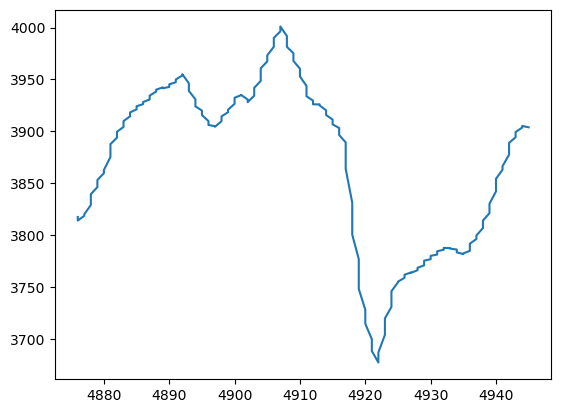

In [186]:
ret['ma3'] = ret['close'].rolling(window=6).mean()
ret['ma5'] = ret['close'].rolling(window=10).mean()
ret[ret['index']>'20250201']['ma5'].plot()

In [162]:
ret['ma3'] = ret['close'].rolling(window=6).mean()
ret['ma5'] = ret['close'].rolling(window=10).mean()
ret['ma30'] = ret['close'].rolling(window=60).mean()
ret['ma3_diff1'] = ret['ma3'].diff(1)
ret['ma3_diff1_shift1'] = ret['ma3_diff1'].shift(-1)
ret['ma5_diff1'] = ret['ma5'].diff(1)
ret['ma5_diff1_shift1'] = ret['ma5_diff1'].shift(-1)
ret['slope'] = ret['ma3_diff1_shift1'] / ret['ma3']
ret['slope'] = ret['slope'].shift(1)
ret['slope_shift1'] = ret['slope'].shift(1)
ret['slope_diff1'] = ret['slope'].diff(1)
ret['close_ma30_diff'] = ret['close'] - ret['ma30']
ret

,index,time,open,high,low,close,volume,amount,settelementPrice,openInterest,...,ma5,ma30,ma3_diff1,ma3_diff1_shift1,ma5_diff1,ma5_diff1_shift1,slope,slope_shift1,slope_diff1,close_ma30_diff
0,20050104,1104768000000,994.770,994.770,980.660,982.790,7412869,4.431980e+09,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,20050104,1104768000000,982.790,994.770,980.660,981.580,7412869,4.431980e+09,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20050105,1104854400000,981.580,997.320,979.880,992.560,7119109,4.529210e+09,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20050105,1104854400000,992.560,997.320,979.880,993.330,7119109,4.529210e+09,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20050106,1104940800000,993.330,993.790,980.330,983.170,6288029,3.921020e+09,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943,20250515,1747238400000,3907.199,3936.466,3904.907,3898.666,138081749,2.414649e+11,0.0,0,...,3899.3090,3798.122883,-2.821167,-1.195500,5.0047,4.2929,-0.000721,0.000707,-0.001427,100.543117
4944,20250516,1747324800000,3898.666,3903.853,3874.862,3889.086,118405345,2.088357e+11,0.0,0,...,3903.6019,3798.152550,-1.195500,-2.045000,4.2929,1.6037,-0.000306,-0.000721,0.000415,90.933450
4944,20250516,1747324800000,3889.086,3903.853,3874.862,3882.568,118405345,2.088357e+11,0.0,0,...,3905.2056,3797.982350,-2.045000,-11.010667,1.6037,-1.3464,-0.000523,-0.000306,-0.000217,84.585650
4945,20250519,1747584000000,3882.568,3885.589,3866.570,3877.146,98643414,1.848882e+11,0.0,0,...,3903.8592,3797.806700,-11.010667,NaN,-1.3464,NaN,-0.002817,-0.000523,-0.002294,79.339300


<Axes: xlabel='slope', ylabel='Density'>

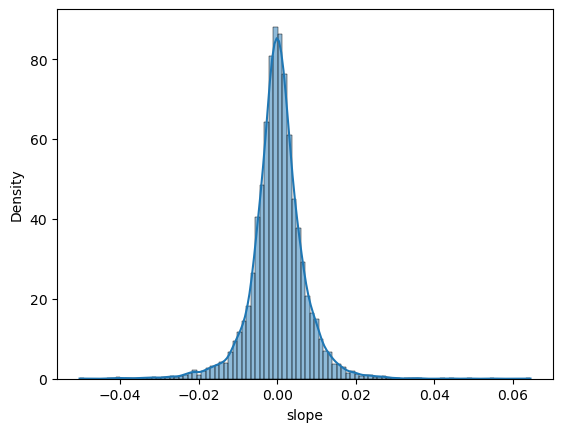

In [140]:
sns.histplot(ret['slope'],element='bars',bins=100,        # 分成20组（箱子个数）
             kde=True,stat= "density")  # 默认绘制，直方图为条形，y轴为计数（观测频数）

In [164]:
slope_90 = ret['slope'].quantile(0.9)
slope_75 = ret['slope'].quantile(0.75)
slope_65 = ret['slope'].quantile(0.65)
slope_55 = ret['slope'].quantile(0.55)
slope_50 = ret['slope'].quantile(0.5)
slope_45 = ret['slope'].quantile(0.45)
slope_35 = ret['slope'].quantile(0.35)
slope_25 = ret['slope'].quantile(0.25)
slope_10 = ret['slope'].quantile(0.1)
print("slope_90 =", round(slope_90, 4),
      '\n'"slope_75 =", round(slope_75, 4),
      '\n'"slope_65 =", round(slope_65, 4),
      '\n'"slope_55 =", round(slope_55, 4),
      '\n'"slope_50 =", round(slope_50, 4),
      '\n'"slope_45 =", round(slope_45, 4),
      '\n'"slope_35 =", round(slope_35, 4),
      '\n'"slope_25 =", round(slope_25, 4),
      '\n'"slope_10 =", round(slope_10, 4)
     )


slope_90 = 0.0055 
slope_75 = 0.0027 
slope_65 = 0.0016 
slope_55 = 0.0006 
slope_50 = 0.0002 
slope_45 = -0.0002 
slope_35 = -0.0012 
slope_25 = -0.0023 
slope_10 = -0.0051


In [172]:
ret[(ret['index']>'20250401') & (ret['slope'] < slope_10)][['index', 'day_or_night', 'slope']]

,index,day_or_night,slope
4917,20250403,2,-0.009357
4918,20250407,1,-0.012947
4918,20250407,2,-0.012597
4919,20250408,1,-0.010406
4919,20250408,2,-0.010681
4920,20250409,1,-0.007948


In [174]:
ret[(ret['index']>'20250401') & (ret['slope'] > slope_90)][['index', 'day_or_night', 'slope']]

,index,day_or_night,slope
4921,20250410,1,0.006658
4921,20250410,2,0.006008
4922,20250411,2,0.007455


In [142]:
skew = ret['close_ma30_diff'].skew()  # 计算偏度系数
kurt = ret['close_ma30_diff'].kurt()  # 计算峰度系数
print("偏度系数 =", round(skew, 4),'\n'"峰度系数 =", round(kurt, 4))

偏度系数 = -0.5066 
峰度系数 = 5.7738


# 量价比

<Axes: >

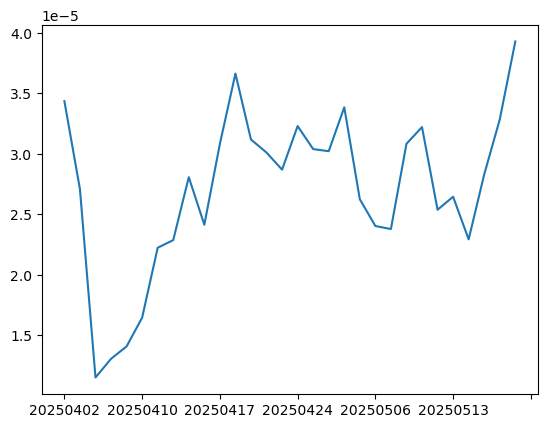

In [195]:
df['close_volume'] = df['close'] / df['volume']
df[df.index > '20250401']['close_volume'].plot()

<Axes: xlabel='close_volume', ylabel='Density'>

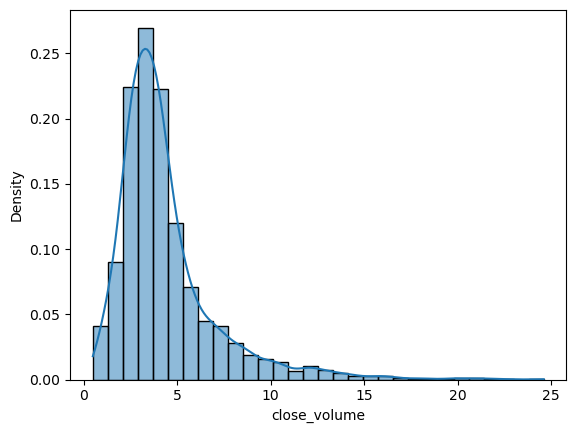

In [203]:
sns.histplot(df['close_volume']*100000,element='bars',bins=30,        # 分成20组（箱子个数）
             kde=True,stat= "density")  # 默认绘制，直方图为条形，y轴为计数（观测频数）

In [205]:
df[['close', 'volume', 'close_volume']].tail(40)

,close,volume,close_volume
20250319,4010.168,144419428,0.000028
20250320,3974.992,133754670,0.000030
20250321,3914.695,165905294,0.000024
20250324,3934.849,152234674,0.000026
20250325,3932.295,140475399,0.000028
20250326,3919.357,131164187,0.000030
20250327,3932.412,126793738,0.000031
20250328,3915.166,126356214,0.000031
20250331,3887.306,166798523,0.000023
20250401,3887.685,140380274,0.000028


# MA均线数据分析

In [103]:
df['ma3'] = df['close'].rolling(window=3).mean()
df['ma5'] = df['close'].rolling(window=5).mean()
df['ma30'] = df['close'].rolling(window=30).mean()
df['ma3_diff1'] = df['ma3'].diff(1)
df['ma3_diff1_shift1'] = df['ma3_diff1'].shift(-1)
df['ma5_diff1'] = df['ma5'].diff(1)
df['ma5_diff1_shift1'] = df['ma5_diff1'].shift(-1)
df['slope'] = df['ma3_diff1_shift1'] / df['ma3']
df['slope'] = df['slope'].shift(1)
df['slope_shift1'] = df['slope'].shift(1)
df['slope_diff1'] = df['slope'].diff(1)
df['close_ma30_diff'] = df['close'] - df['ma30']
df

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,...,ma5,ma30,ma3_diff1,ma3_diff1_shift1,ma5_diff1,ma5_diff1_shift1,slope,slope_shift1,slope_diff1,close_ma30_diff
20050104,1104768000000,994.770,994.770,980.660,982.790,7412869,4.431980e+09,0.0,0,1000.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050105,1104854400000,981.580,997.320,979.880,992.560,7119109,4.529210e+09,0.0,0,982.790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050106,1104940800000,993.330,993.790,980.330,983.170,6288029,3.921020e+09,0.0,0,992.560,...,NaN,NaN,NaN,0.390000,NaN,NaN,NaN,NaN,NaN,NaN
20050107,1105027200000,983.050,995.710,979.810,983.960,7298694,4.737470e+09,0.0,0,983.170,...,NaN,NaN,0.390000,0.440000,NaN,NaN,0.000395,NaN,NaN,NaN
20050110,1105286400000,983.760,993.960,979.790,993.880,5791698,3.762930e+09,0.0,0,983.960,...,987.2720,NaN,0.440000,4.656667,NaN,2.8700,0.000446,0.000395,0.000051,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250513,1747065600000,3915.593,3915.593,3890.686,3896.259,147320299,2.675864e+11,0.0,0,3890.610,...,3863.5098,3799.981633,14.454333,32.351000,17.5434,22.3166,0.003742,0.005115,-0.001374,96.277367
20250514,1747152000000,3894.838,3960.522,3890.650,3943.210,172033779,3.194652e+11,0.0,0,3896.258,...,3885.8264,3800.341567,32.351000,5.529667,22.3166,10.8606,0.008343,0.003742,0.004601,142.868433
20250515,1747238400000,3934.027,3936.466,3904.907,3907.199,138081749,2.414649e+11,0.0,0,3943.211,...,3896.6870,3800.076000,5.529667,-2.391000,10.8606,8.5858,0.001414,0.008343,-0.006929,107.123000
20250516,1747324800000,3898.666,3903.853,3874.862,3889.086,118405345,2.088357e+11,0.0,0,3907.199,...,3905.2728,3800.135333,-2.391000,-22.021333,8.5858,-2.6928,-0.000611,0.001414,-0.002025,88.950667


<Axes: xlabel='close_ma30_diff', ylabel='Density'>

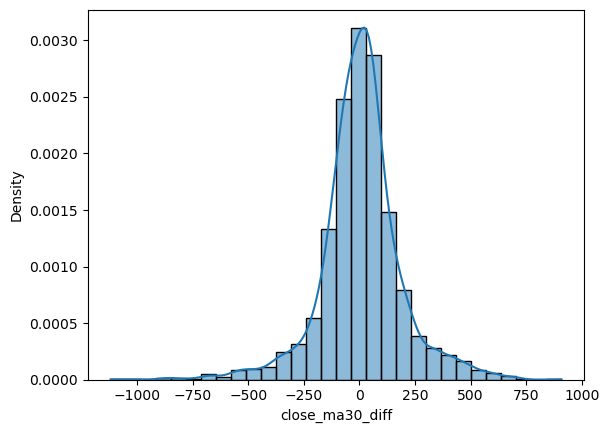

In [105]:
sns.histplot(df['close_ma30_diff'],element='bars',bins=30,        # 分成20组（箱子个数）
             kde=True,stat= "density")  # 默认绘制，直方图为条形，y轴为计数（观测频数）

In [331]:
skew = df['close_ma30_diff'].skew()  # 计算偏度系数
kurt = df['close_ma30_diff'].kurt()  # 计算峰度系数
print("偏度系数 =", round(skew, 4),'\n'"峰度系数 =", round(kurt, 4))

quant_65 = df['close_ma30_diff'].quantile(0.65)
quant_35 = df['close_ma30_diff'].quantile(0.35)
print("65分位 =", round(quant_65, 4),'\n'"35分位 =", round(quant_35, 4))

quant_75 = df['close_ma30_diff'].quantile(0.75)
quant_25 = df['close_ma30_diff'].quantile(0.25)
print("75分位 =", round(quant_75, 4),'\n'"25分位 =", round(quant_25, 4))

quant_80 = df['close_ma30_diff'].quantile(0.80)
quant_20 = df['close_ma30_diff'].quantile(0.20)
print("80分位 =", round(quant_80, 4),'\n'"20分位 =", round(quant_20, 4))

quant_85 = df['close_ma30_diff'].quantile(0.85)
quant_15 = df['close_ma30_diff'].quantile(0.15)
print("85分位 =", round(quant_85, 4),'\n'"15分位 =", round(quant_15, 4))

quant_90 = df['close_ma30_diff'].quantile(0.90)
quant_10 = df['close_ma30_diff'].quantile(0.10)
print("90分位 =", round(quant_90, 4),'\n'"10分位 =", round(quant_10, 4))

偏度系数 = -0.1955 
峰度系数 = 3.2632
65分位 = 54.72 
35分位 = -41.3266
75分位 = 91.5792 
25分位 = -78.3141
80分位 = 116.7319 
20分位 = -101.7015
85分位 = 153.2755 
15分位 = -130.04
90分位 = 206.4693 
10分位 = -177.0823


In [321]:
df[df['close_ma30_diff'] > 900]

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,...,ma5_diff1,ma5_diff1_shift1,slope,slope_diff1,slope_shift1,ma30,ma3,ma3_diff1,ma3_diff1_shift1,close_ma30_diff
20241008,1728316800000,4450.368,4450.368,4094.352,4256.096,589867894,1.130387e+12,0.0,0,4017.855,...,180.8372,110.8902,0.050176,0.00341,0.046766,3347.0109,3992.545333,236.925333,84.099667,909.0851


In [305]:
slope_diff1_90 = df['slope_diff1'].quantile(0.9)
slope_diff1_75 = df['slope_diff1'].quantile(0.75)
slope_diff1_65 = df['slope_diff1'].quantile(0.65)
slope_diff1_50 = df['slope_diff1'].quantile(0.5)
slope_diff1_35 = df['slope_diff1'].quantile(0.35)
slope_diff1_25 = df['slope_diff1'].quantile(0.25)
slope_diff1_10 = df['slope_diff1'].quantile(0.1)
print(slope_diff1_90, slope_diff1_75, slope_diff1_65, slope_diff1_50, slope_diff1_35, slope_diff1_25, slope_diff1_10)

slope_90 = df['slope'].quantile(0.9)
slope_75 = df['slope'].quantile(0.75)
slope_65 = df['slope'].quantile(0.65)
slope_55 = df['slope'].quantile(0.55)
slope_50 = df['slope'].quantile(0.5)
slope_45 = df['slope'].quantile(0.45)
slope_35 = df['slope'].quantile(0.35)
slope_25 = df['slope'].quantile(0.25)
slope_10 = df['slope'].quantile(0.1)
print(slope_90, slope_75, slope_65, slope_55, slope_50, slope_45, slope_35, slope_25, slope_10)

0.008001557458711431 0.003732292691722523 0.001903717394311006 -9.89222348627924e-05 -0.002056134387714062 -0.003827299520086707 -0.0082197213929375
0.010779424544467798 0.005515723042489072 0.003224038806757782 0.0012663919827224537 0.0004157720212169995 -0.00042545692548455575 -0.0023738250500852857 -0.004508766269138605 -0.009991687744815042


In [333]:
df[(df.index >= '20250401') & (df.index <= '20250530')][
['close', 'ma5', 'ma30', 'ma5_diff1', 'ma5_diff1_shift1','slope', 'slope_shift1', 'slope_diff1', 'close_ma30_diff']]

,close,ma5,ma30,ma5_diff1,ma5_diff1_shift1,slope,slope_shift1,slope_diff1,close_ma30_diff
20250401,3887.685,3908.3852,3938.883733,-8.9220,-6.9942,-0.002278,-0.002421,0.000144,-51.198733
20250402,3884.386,3901.3910,3937.024567,-6.9942,-14.1816,-0.001790,-0.002278,0.000488,-52.638567
20250403,3861.504,3887.2094,3934.778167,-14.1816,-65.1450,-0.003635,-0.001790,-0.001845,-73.274167
20250407,3589.441,3822.0644,3921.811400,-65.1450,-47.3094,-0.016759,-0.003635,-0.013124,-332.370400
20250408,3650.759,3774.7550,3911.179467,-47.3094,-40.1782,-0.012378,-0.016759,0.004381,-260.420467
20250409,3686.794,3734.5768,3903.217567,-40.1782,-29.8542,-0.010644,-0.012378,0.001734,-216.423567
20250410,3735.115,3704.7226,3895.723367,-29.8542,-22.1974,-0.007994,-0.010644,0.002650,-160.608367
20250411,3750.517,3682.5252,3888.470067,-22.1974,33.9402,-0.005992,-0.007994,0.002002,-137.953067
20250414,3759.142,3716.4654,3884.106533,33.9402,22.0952,0.009217,-0.005992,0.015208,-124.964533
20250415,3761.235,3738.5606,3879.865233,22.0952,17.2054,0.005945,0.009217,-0.003271,-118.630233


# 根据close_ma30_diff计算仓位

# 买点

In [287]:
df[(df.index >= '20241101') & (df['close'] < df['ma30']) & (df['ma5'] < df['ma30']) & (df['slope'] > 0.001) & (df['slope_shift1'] < 0) & (df['slope_diff1'] > slope_diff1_65)][
['close', 'ma3', 'ma5', 'ma30', 'ma5_diff1', 'ma5_diff1_shift1','slope', 'slope_shift1', 'slope_diff1']]

,close,ma3,ma5,ma30,ma5_diff1,ma5_diff1_shift1,slope,slope_shift1,slope_diff1
20241127,3907.045,3865.107000,3890.0636,3966.238100,-15.7454,-23.3494,0.003579,-0.012741,0.016320
20250108,3789.216,3784.763667,3789.9700,3924.596700,-29.1390,-8.1036,0.001239,-0.002137,0.003376
20250114,3820.540,3758.511333,3768.9254,3904.983367,4.8870,1.3622,0.003619,-0.005902,0.009521
20250120,3829.677,3814.134333,3811.7940,3887.025133,21.4328,2.4148,0.002949,-0.000718,0.003667
20250410,3735.115,3690.889333,3704.7226,3895.723367,-29.8542,-22.1974,0.013332,-0.015737,0.029069
20250506,3808.542,3784.729667,3784.5602,3811.936267,4.8370,8.9268,0.002377,-0.001448,0.003825


# 卖点

In [289]:
df[(df.index >= '20241101') & (df['close'] > df['ma30']) & (df['ma5'] > df['ma30']) & (df['slope'] < -0.001) & (df['slope_shift1'] > 0) & (df['slope_diff1'] < slope_diff1_35)][
['close', 'ma3', 'ma5', 'ma30', 'ma5_diff1', 'ma5_diff1_shift1','slope', 'slope_shift1', 'slope_diff1']]

,close,ma3,ma5,ma30,ma5_diff1,ma5_diff1_shift1,slope,slope_shift1,slope_diff1
20241112,4085.743,4106.973667,4098.1798,3930.626533,8.2340,17.3214,-0.004842,0.008705,-0.013548
20241114,4039.619,4078.750667,4094.2860,3970.748400,-21.2152,-27.0432,-0.007423,0.000555,-0.007979
20250311,3941.416,3938.077333,3934.6080,3901.001167,11.2392,4.9322,-0.001253,0.002222,-0.003475
20250320,3974.992,3997.627667,3999.2454,3938.127933,12.6824,-18.3724,-0.001814,0.000301,-0.002115


In [299]:
#(3.829 + 3.72 + 3.753 + 3.763 - 2 * 3.874 - 2 * 3.914) * 10000
#(3.829 + 3.72 + 3.753 + 3.763 - 1 * 3.874 - 3 * 3.914) * 10000
(3.829 + 3.72 + 3.753 + 3.763 - 4 * 3.874 - 0 * 3.914) * 10000
#(3.829 + 3.72 + 3.753 + 3.763 - 0 * 3.874 - 4 * 3.914) * 10000

-4310.000000000009

In [283]:
(3.909 -3.863) * 10000

459.9999999999982

In [285]:
(3.72+3.754+3.763 - 3 * 3.874) * 10000

-3849.9999999999977

In [246]:
#((3890.048-3820.540)/3820.540) * 50000
(3.836-3.753)*10000

829.9999999999974

In [248]:
#((3911.580-3842.832)/3842.832) * 50000
(3.847-3.777)*10000

699.9999999999984

# 增加买卖条件
# 当前沪深300指数位置 ma5 > ma30 ma5 < ma30
# 计算更敏感的移动平均线 3日

In [263]:
df['ma3'] = df['close'].rolling(window=3).mean()
df['ma5'] = df['close'].rolling(window=5).mean()
df['ma30'] = df['close'].rolling(window=30).mean()
df['ma3_diff1'] = df['ma3'].diff(1)
df['ma3_diff1_shift1'] = df['ma3_diff1'].shift(-1)
df['slope'] = df['ma3_diff1_shift1'] / df['ma3']
df['slope'] = df['slope'].shift(1)
df['slope_shift1'] = df['slope'].shift(1)
df['slope_diff1'] = df['slope'].diff(1)
df

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,...,ma5,ma5_diff1,ma5_diff1_shift1,slope,slope_diff1,slope_shift1,ma30,ma3,ma3_diff1,ma3_diff1_shift1
20050104,1104768000000,994.770,994.770,980.660,982.790,7412869,4.431980e+09,0.0,0,1000.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050105,1104854400000,981.580,997.320,979.880,992.560,7119109,4.529210e+09,0.0,0,982.790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20050106,1104940800000,993.330,993.790,980.330,983.170,6288029,3.921020e+09,0.0,0,992.560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,986.173333,NaN,0.390000
20050107,1105027200000,983.050,995.710,979.810,983.960,7298694,4.737470e+09,0.0,0,983.170,...,NaN,NaN,NaN,0.000395,NaN,NaN,NaN,986.563333,0.390000,0.440000
20050110,1105286400000,983.760,993.960,979.790,993.880,5791698,3.762930e+09,0.0,0,983.960,...,987.2720,NaN,2.8700,0.000446,0.000051,0.000395,NaN,987.003333,0.440000,4.656667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250513,1747065600000,3915.593,3915.593,3890.686,3896.259,147320299,2.675864e+11,0.0,0,3890.610,...,3863.5098,17.5434,22.3166,0.003742,-0.001374,0.005115,3799.981633,3877.675333,14.454333,32.351000
20250514,1747152000000,3894.838,3960.522,3890.650,3943.210,172033779,3.194652e+11,0.0,0,3896.258,...,3885.8264,22.3166,10.8606,0.008343,0.004601,0.003742,3800.341567,3910.026333,32.351000,5.529667
20250515,1747238400000,3934.027,3936.466,3904.907,3907.199,138081749,2.414649e+11,0.0,0,3943.211,...,3896.6870,10.8606,8.5858,0.001414,-0.006929,0.008343,3800.076000,3915.556000,5.529667,-2.391000
20250516,1747324800000,3898.666,3903.853,3874.862,3889.086,118405345,2.088357e+11,0.0,0,3907.199,...,3905.2728,8.5858,-2.7816,-0.000611,-0.002025,0.001414,3800.135333,3913.165000,-2.391000,-22.169333


In [131]:
df[(df.index >= '20250101') & (df['slope_diff1'] <= slope_diff1_10) & ((df['slope'] >= slope_75) | (df['slope'] <= slope_25))]

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,ma5,ma5_diff1,ma5_diff1_shift1,slope,slope_diff1
20250102,1735747200000,3931.816,3934.204,3796.339,3820.395,217898724,3.886366e+11,0.0,0,3934.911,0,3944.5742,-33.0468,-42.4632,-0.010765,-0.005862
20250228,1740672000000,3950.186,3972.481,3886.399,3890.048,198104147,4.203080e+11,0.0,0,3968.116,0,3942.6946,-17.6792,-16.2486,-0.004121,-0.006449
20250407,1743955200000,3675.202,3707.778,3514.117,3589.441,312578586,5.129718e+11,0.0,0,3861.504,0,3822.0644,-65.1450,-47.3094,-0.012378,-0.013124


# volume 数据分析

0.004360323477682155 -0.0035852498494264398


In [235]:
_mean = df['volume'].mean()
_var = df['volume'].var()
_mode = df['volume'].mode()
quant_75 = df['volume'].quantile(0.75)
quant_25 = df['volume'].quantile(0.25)
quant_90 = df['volume'].quantile(0.9)
quant_10 = df['volume'].quantile(0.1)
quant_95 = df['volume'].quantile(0.95)
quant_05 = df['volume'].quantile(0.05)
quant_05

95530175.8

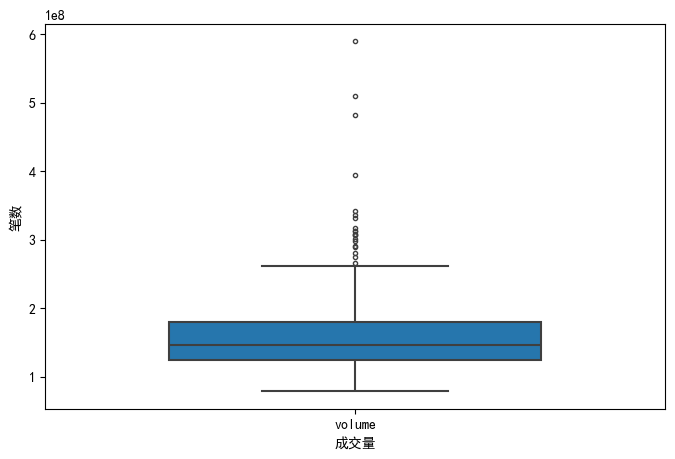

In [237]:

### 绘制箱形图
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

df1= pd.melt(df, value_vars=['volume'], 
             var_name='成交量', value_name='笔数')  # 融合数据
plt.figure(figsize=(8, 5))
sns.boxplot(data=df1,x='成交量',y='笔数',
            width=0.6,linewidth=1.5,    # 设置箱子的宽度和线宽
            saturation=0.9,  # 设置颜色的原始饱和度比例。1表示完全饱和
            fliersize=3,     # 设置离群点标记的大小
            notch=False,     # 设置notch可绘制出箱子的凹槽

            orient="v")      # 如果变量是在行的位置，可设置orient="h",绘制水平箱线图

plt.show()

In [239]:
df['ma5'] = df['volume'].rolling(window=5).mean()
df['volume_ma5'] = df['volume'] / df['ma5']
df['daily_return'] = df['close'] / df['preClose']

<Axes: xlabel='daily_return', ylabel='Density'>

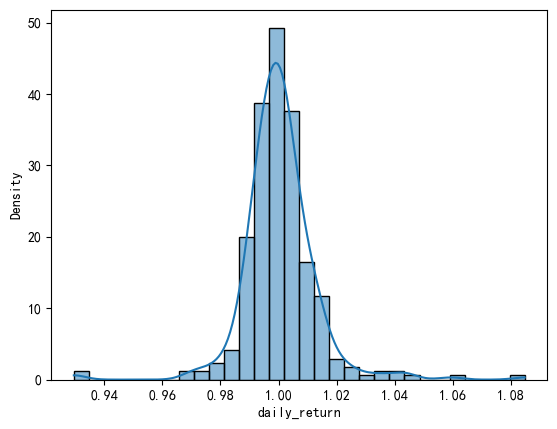

In [241]:
sns.histplot(df['daily_return'],element='bars',bins=30,        # 分成20组（箱子个数）
             kde=True,stat= "density")  # 默认绘制，直方图为条形，y轴为计数（观测频数）

In [243]:
df[(df['volume'] < quant_10) & (df['volume_ma5'] < 0.9) & (df['daily_return'] > 1)]

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,ma5,volume_ma5,daily_return
20240808,1723046400000,3332.428,3364.785,3320.843,3342.937,92495695,1.494829e+11,0.0,0,3341.489,0,113269624.4,0.816598,1.000433
20240905,1725465600000,3252.960,3266.882,3247.173,3257.758,97109450,1.346182e+11,0.0,0,3252.165,0,132229406.8,0.734401,1.001720
20250418,1744905600000,3760.042,3782.044,3754.407,3772.523,102948509,1.731094e+11,0.0,0,3772.222,0,136029392.0,0.756811,1.000080


In [245]:
df[(df['volume'] > quant_90) & (df['volume_ma5'] > 1.1) & (df['daily_return'] < 1)]

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,ma5,volume_ma5,daily_return
20241009,1728403200000,4168.844,4197.600,3942.512,3955.984,482269295,1.029032e+12,0.0,0,4256.096,0,418195336.0,1.153215,0.929487
20241101,1730390400000,3882.458,3933.221,3879.959,3890.020,307986481,4.764730e+11,0.0,0,3891.040,0,252302844.8,1.220702,0.999738
20241106,1730822400000,4051.289,4091.703,4002.503,4024.283,335807938,6.391241e+11,0.0,0,4044.573,0,298106598.2,1.126469,0.994983
20241118,1731859200000,3982.103,4034.059,3931.187,3950.380,306777946,4.724081e+11,0.0,0,3968.831,0,264518475.6,1.159760,0.995351
20241213,1734019200000,4000.985,4000.985,3931.739,3933.181,230353079,4.214786e+11,0.0,0,4028.505,0,203730291.0,1.130677,0.976338
20250407,1743955200000,3675.202,3707.778,3514.117,3589.441,312578586,5.129718e+11,0.0,0,3861.504,0,175080069.4,1.785346,0.929545


In [247]:
df[df['daily_return'] > 1.03]

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,ma5,volume_ma5,daily_return
20240206,1707148800000,3185.250,3314.512,3182.822,3311.693,202713099,2.850420e+11,0.0,0,3200.422,0,175634883.8,1.154173,1.034768
20240924,1727107200000,3244.647,3351.969,3222.489,3351.910,204072217,3.078795e+11,0.0,0,3212.764,0,125528651.2,1.625702,1.043310
20240926,1727280000000,3399.319,3545.325,3391.677,3545.320,243134010,3.739836e+11,0.0,0,3401.533,0,180435887.0,1.347481,1.042271
20240927,1727366400000,3617.920,3708.495,3596.583,3703.685,265487774,4.666928e+11,0.0,0,3545.320,0,209920622.2,1.264706,1.044669
20240930,1727625600000,3846.652,4038.697,3796.505,4017.855,510217707,8.625288e+11,0.0,0,3703.685,0,292895192.6,1.741980,1.084826
20241008,1728316800000,4450.368,4450.368,4094.352,4256.096,589867894,1.130387e+12,0.0,0,4017.855,0,370054328.0,1.594003,1.059296
20241018,1729180800000,3780.315,3998.214,3765.162,3925.234,312958834,6.206737e+11,0.0,0,3788.222,0,258840900.4,1.209078,1.036168
20241107,1730908800000,3987.266,4146.151,3984.665,4145.695,341436414,6.581459e+11,0.0,0,4024.283,0,306266537.4,1.114834,1.030170


In [249]:
df[df['daily_return'] < 0.97]

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,ma5,volume_ma5,daily_return
20241009,1728403200000,4168.844,4197.600,3942.512,3955.984,482269295,1.029032e+12,0.0,0,4256.096,0,418195336.0,1.153215,0.929487
20241122,1732204800000,3984.244,3990.265,3865.699,3865.699,216285809,3.975668e+11,0.0,0,3989.298,0,223347103.8,0.968384,0.969017
20250407,1743955200000,3675.202,3707.778,3514.117,3589.441,312578586,5.129718e+11,0.0,0,3861.504,0,175080069.4,1.785346,0.929545


# LSTM

In [466]:
data = df

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# 构建序列数据
window = 5
X = np.array([data['close'].values[i-window:i] 
             for i in range(window, len(data))])
y = np.array([1 if i in max_idx 
             else 0 for i in range(window, len(data))])

# 训练模型
model = Sequential([
    LSTM(50, input_shape=(window, 1)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(X.reshape(-1, window, 1), y, epochs=20)

# 预测拐点概率
prob_turning = model.predict(X[-100:])

Epoch 1/20


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3674
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3159
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3057
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2992
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3023
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2646
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2721
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2634
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2362
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2187
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2227
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2310
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2345
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2237
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2469 
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/

In [87]:
prob_turning = model.predict(X)
prob_turning

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.10041975],
       [0.100

In [66]:
len(y)

148

In [68]:
i = 31
data['close'].values[i-window:i]

array([4024.283, 4145.695, 4104.047, 4131.131, 4085.743])

# 极值点检测（导数法）

C:\Users\DELL\AppData\Local\Temp\ipykernel_26788\1875035206.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(data.index[max_idx], data['close'][max_idx], c='red')
C:\Users\DELL\AppData\Local\Temp\ipykernel_26788\1875035206.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(data.index[min_idx], data['close'][min_idx], c='green')


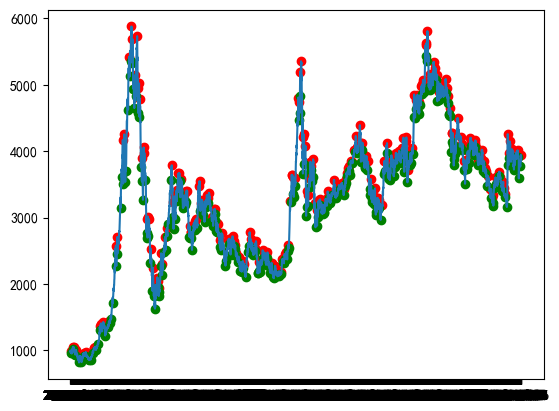

In [468]:
from scipy.signal import argrelextrema

# 寻找局部极值
max_idx = argrelextrema(data['close'].values, np.greater, order=5)[0]  # 顶部
min_idx = argrelextrema(data['close'].values, np.less, order=5)[0]     # 底部

# 可视化标记
plt.plot(data['close'])
plt.scatter(data.index[max_idx], data['close'][max_idx], c='red')
plt.scatter(data.index[min_idx], data['close'][min_idx], c='green')

In [469]:
max_idx

array([   5,   14,   31,   38,   61,  100,  112,  123,  147,  172,  184,
        192,  199,  216,  258,  265,  275,  328,  338,  358,  365,  374,
        416,  424,  500,  515,  576,  591,  645,  671,  682,  711,  733,
        748,  754,  763,  788,  805,  812,  842,  851,  862,  881,  907,
        938,  955,  962,  972,  996, 1009, 1040, 1060, 1112, 1127, 1145,
       1166, 1186, 1196, 1214, 1237, 1252, 1274, 1281, 1308, 1320, 1326,
       1368, 1381, 1407, 1417, 1430, 1443, 1457, 1486, 1498, 1510, 1521,
       1559, 1578, 1586, 1607, 1615, 1633, 1646, 1660, 1738, 1745, 1779,
       1795, 1809, 1822, 1846, 1868, 1885, 1893, 1902, 1967, 1978, 1994,
       2012, 2022, 2036, 2065, 2088, 2110, 2125, 2150, 2162, 2181, 2198,
       2209, 2234, 2246, 2266, 2278, 2290, 2306, 2325, 2336, 2349, 2367,
       2391, 2409, 2429, 2436, 2442, 2462, 2501, 2511, 2521, 2530, 2554,
       2562, 2574, 2594, 2603, 2623, 2632, 2644, 2663, 2682, 2701, 2712,
       2721, 2731, 2738, 2752, 2759, 2773, 2799, 28

In [470]:
min_idx

array([  12,   19,   34,   54,   96,  104,  122,  150,  158,  179,  187,
        196,  208,  222,  250,  281,  306,  331,  345,  370,  383,  419,
        433,  448,  467,  505,  516,  553,  566,  580,  603,  610,  634,
        651,  662,  678,  691,  702,  716,  747,  759,  774,  785,  797,
        820,  837,  845,  857,  879,  901,  916,  929,  947,  957,  970,
        977,  998, 1005, 1032, 1045, 1065, 1076, 1109, 1124, 1132, 1153,
       1169, 1190, 1198, 1207, 1236, 1253, 1260, 1268, 1303, 1318, 1324,
       1335, 1363, 1372, 1390, 1424, 1434, 1440, 1453, 1472, 1487, 1504,
       1514, 1553, 1567, 1583, 1592, 1602, 1612, 1642, 1650, 1702, 1709,
       1741, 1757, 1793, 1803, 1816, 1839, 1865, 1880, 1898, 1923, 1949,
       1959, 1980, 1990, 2008, 2017, 2026, 2055, 2063, 2071, 2077, 2096,
       2118, 2135, 2147, 2156, 2178, 2194, 2202, 2217, 2224, 2232, 2239,
       2258, 2265, 2271, 2282, 2293, 2308, 2328, 2343, 2359, 2379, 2388,
       2397, 2421, 2437, 2451, 2466, 2508, 2515, 25

In [536]:
#data['idx'] = data.apply(lambda x: 1 if x.index in data.index[max_idx] else 0)
#data['idx'] = data.apply(lambda x: print(x.index))
max_idx_df = pd.DataFrame(index=data.index[max_idx])
max_idx_df['idx'] = 1
max_idx_df
min_idx_df = pd.DataFrame(index=data.index[min_idx])
min_idx_df['idx'] = -1
min_idx_df
idx_df = pd.concat([max_idx_df, min_idx_df])

data.columns
data.drop(['idx'], inplace=True, axis=1)
data = data.join(idx_df)
data

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,idx
20050104,1104768000000,994.770,994.770,980.660,982.790,7412869,4.431980e+09,0.0,0,1000.000,0,NaN
20050105,1104854400000,981.580,997.320,979.880,992.560,7119109,4.529210e+09,0.0,0,982.790,0,NaN
20050106,1104940800000,993.330,993.790,980.330,983.170,6288029,3.921020e+09,0.0,0,992.560,0,NaN
20050107,1105027200000,983.050,995.710,979.810,983.960,7298694,4.737470e+09,0.0,0,983.170,0,NaN
20050110,1105286400000,983.760,993.960,979.790,993.880,5791698,3.762930e+09,0.0,0,983.960,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
20250512,1746979200000,3866.531,3890.735,3859.035,3890.610,153332460,2.961229e+11,0.0,0,3846.157,0,NaN
20250513,1747065600000,3915.593,3915.593,3890.686,3896.259,147320299,2.675864e+11,0.0,0,3890.610,0,NaN
20250514,1747152000000,3894.838,3960.522,3890.650,3943.210,172033779,3.194652e+11,0.0,0,3896.258,0,1.0
20250515,1747238400000,3934.027,3936.466,3904.907,3907.199,138081749,2.414649e+11,0.0,0,3943.211,0,NaN


In [546]:
data['idx'].fillna(0, inplace=True)
#data.columns

# 曲率突变检测

In [259]:
# 计算二阶导数（加速度）
smooth = data['close'].rolling(10).mean()
smoothed_first_deriv = smooth.diff()
smoothed_second_deriv = first_deriv.diff()

unsmoothed_first_deriv = data['close'].diff()
unsmoothed_second_deriv = unsmoothed_first_deriv.diff()

# 曲率阈值法
inflection_points = data.index[abs(unsmoothed_first_deriv) > 3*np.std(unsmoothed_first_deriv)]

<Axes: >

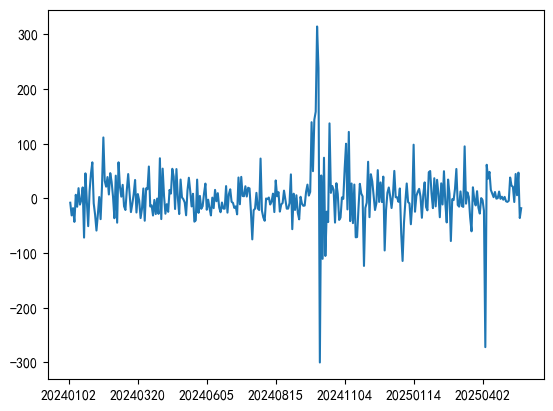

In [261]:
unsmoothed_first_deriv.plot()
#unsmoothed_first_deriv.hist()

<BarContainer object of 329 artists>

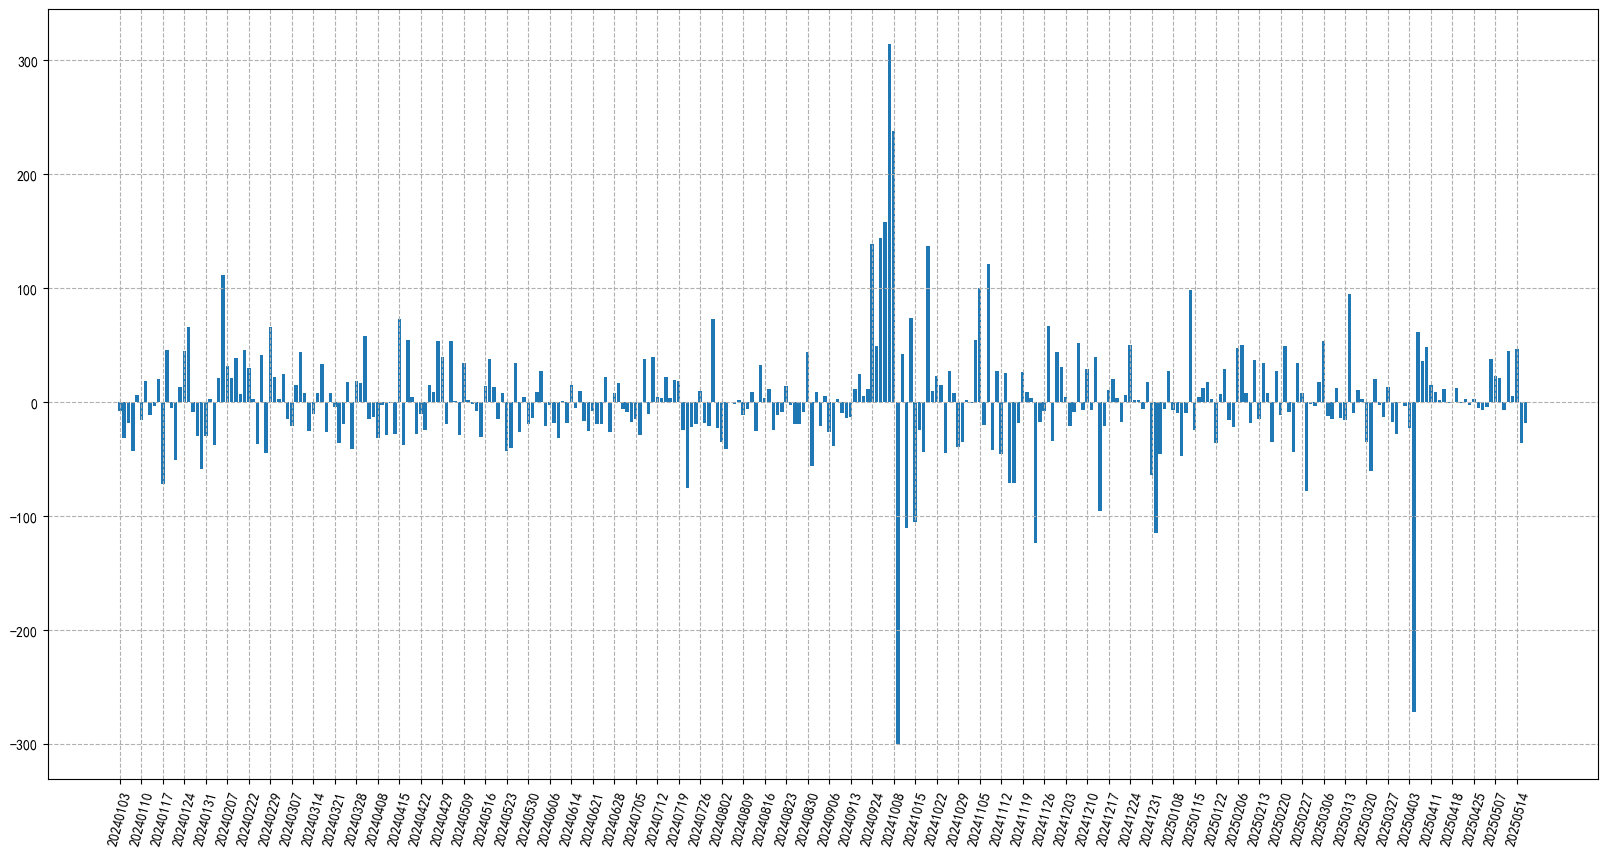

In [263]:
#unsmoothed_second_deriv.plot()
#unsmoothed_second_deriv.hist()
plt.figure(figsize=(20,10))
plt.grid(ls='--')
plt.xticks(range(1, len(unsmoothed_first_deriv.index), 5), rotation=75)
plt.bar(unsmoothed_first_deriv.index, unsmoothed_first_deriv)

In [265]:
unsmoothed_first_deriv[unsmoothed_first_deriv < -100]

20241009   -300.112
20241011   -110.621
20241015   -105.347
20241122   -123.599
20250102   -114.516
20250407   -272.063
Name: close, dtype: float64

<BarContainer object of 329 artists>

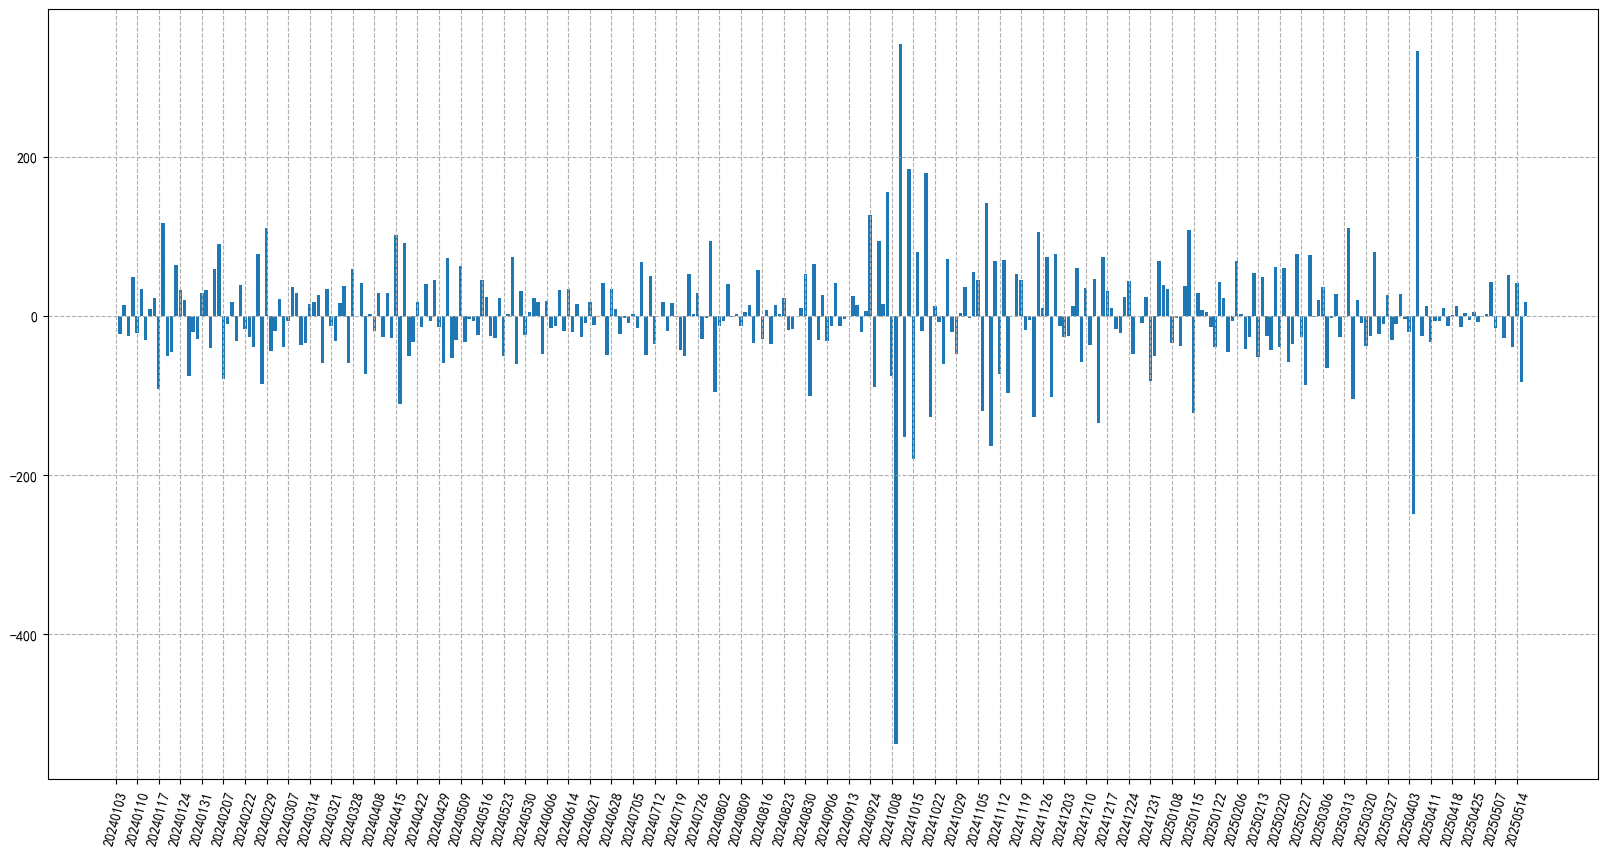

In [267]:
plt.figure(figsize=(20,10))
plt.grid(ls='--')
plt.xticks(range(1, len(unsmoothed_second_deriv.index), 5), rotation=75)
plt.bar(unsmoothed_second_deriv.index, unsmoothed_second_deriv)

In [269]:
unsmoothed_second_deriv[unsmoothed_second_deriv<-100]

20240416   -111.198
20240902   -100.173
20241009   -538.353
20241011   -152.425
20241015   -179.522
20241021   -127.049
20241106   -120.101
20241108   -163.060
20241122   -127.125
20241128   -101.354
20241213   -134.998
20250115   -122.540
20250317   -104.747
20250407   -249.181
Name: close, dtype: float64

In [271]:
unsmoothed_first_deriv.loc[inflection_points]

20240927    158.365
20240930    314.170
20241008    238.241
20241009   -300.112
20250407   -272.063
Name: close, dtype: float64

In [273]:
unsmoothed_second_deriv.loc[inflection_points]

20240927     14.578
20240930    155.805
20241008    -75.929
20241009   -538.353
20250407   -249.181
Name: close, dtype: float64

In [275]:
inflection_points = data.index[abs(unsmoothed_second_deriv) > 3*np.std(unsmoothed_second_deriv)]

In [277]:
unsmoothed_first_deriv

20240102       NaN
20240103    -8.055
20240104   -31.245
20240105   -17.941
20240108   -43.055
             ...  
20250512    44.453
20250513     5.649
20250514    46.951
20250515   -36.011
20250516   -18.113
Name: close, Length: 329, dtype: float64

<Axes: >

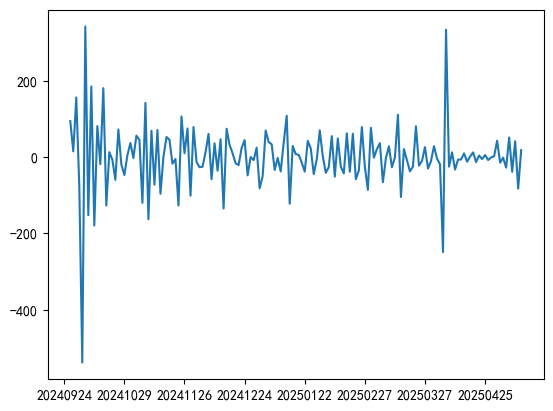

In [166]:
plt.plot(

In [281]:
ret = pd.DataFrame() 

ret['delta'] = unsmoothed_first_deriv
ret['gamma'] = unsmoothed_second_deriv

TypeError: bar() missing 1 required positional argument: 'height'

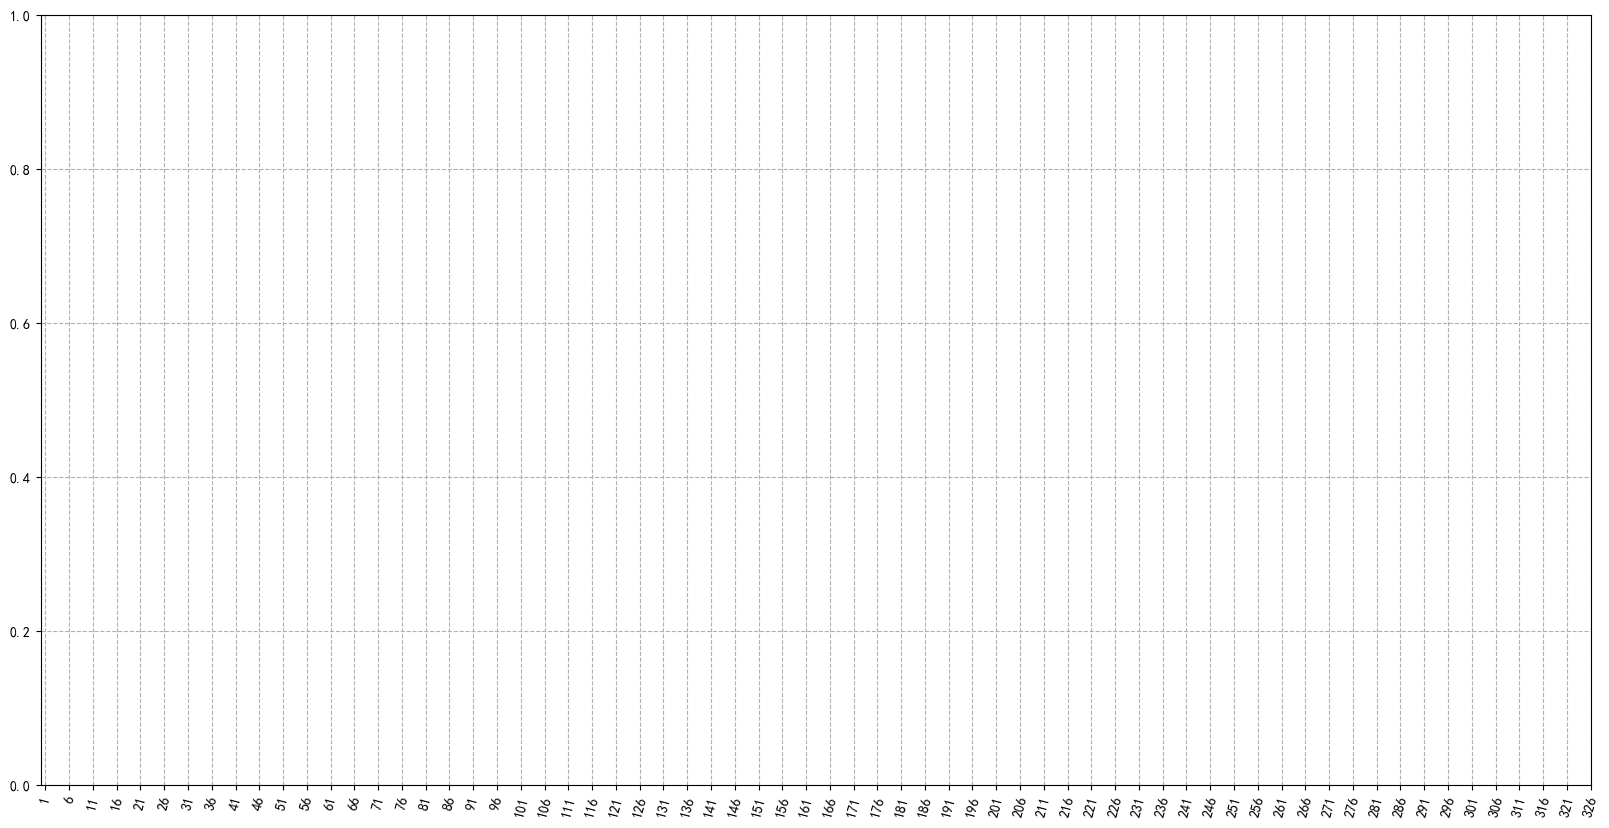

In [283]:
plt.figure(figsize=(20,10))
plt.grid(ls='--')
plt.xticks(range(1, len(unsmoothed_first_deriv.index), 5), rotation=75)
plt.bar(ret)

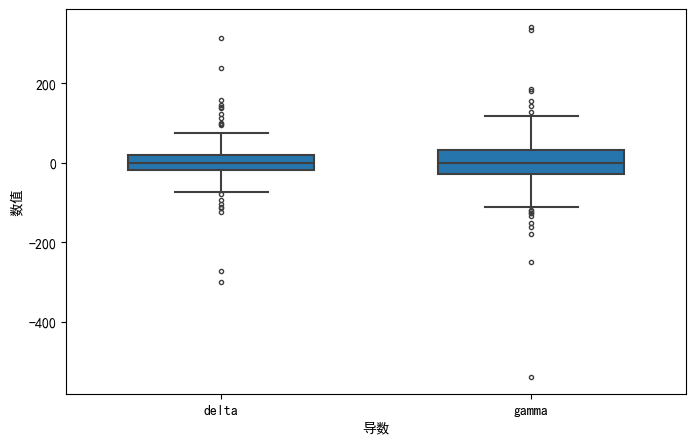

In [285]:
df1= pd.melt(ret, value_vars=['delta', 'gamma'], 
             var_name='导数', value_name='数值')  # 融合数据
plt.figure(figsize=(8, 5))
sns.boxplot(data=df1,x='导数',y='数值',
            width=0.6,linewidth=1.5,    # 设置箱子的宽度和线宽
            saturation=0.9,  # 设置颜色的原始饱和度比例。1表示完全饱和
            fliersize=3,     # 设置离群点标记的大小
            notch=False,     # 设置notch可绘制出箱子的凹槽

            orient="v")      # 如果变量是在行的位置，可设置orient="h",绘制水平箱线图

plt.show()

# 斜率变化

In [203]:
data

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,ma5,volume_ma5,daily_return
20240924,1727107200000,3244.647,3351.969,3222.489,3351.910,204072217,3.078795e+11,0.0,0,3212.764,0,NaN,NaN,1.043310
20240925,1727193600000,3403.702,3465.488,3393.438,3401.533,241564255,3.568626e+11,0.0,0,3351.909,0,NaN,NaN,1.014805
20240926,1727280000000,3399.319,3545.325,3391.677,3545.320,243134010,3.739836e+11,0.0,0,3401.533,0,NaN,NaN,1.042271
20240927,1727366400000,3617.920,3708.495,3596.583,3703.685,265487774,4.666928e+11,0.0,0,3545.320,0,NaN,NaN,1.044669
20240930,1727625600000,3846.652,4038.697,3796.505,4017.855,510217707,8.625288e+11,0.0,0,3703.685,0,292895192.6,1.741980,1.084826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250512,1746979200000,3866.531,3890.735,3859.035,3890.610,153332460,2.961229e+11,0.0,0,3846.157,0,143474915.4,1.068706,1.011558
20250513,1747065600000,3915.593,3915.593,3890.686,3896.259,147320299,2.675864e+11,0.0,0,3890.610,0,141234883.4,1.043087,1.001452
20250514,1747152000000,3894.838,3960.522,3890.650,3943.210,172033779,3.194652e+11,0.0,0,3896.258,0,143407179.4,1.199618,1.012051
20250515,1747238400000,3934.027,3936.466,3904.907,3907.199,138081749,2.414649e+11,0.0,0,3943.211,0,146031562.6,0.945561,0.990867


In [289]:
data['slope'] = data['close'] - data['preClose']

<BarContainer object of 329 artists>

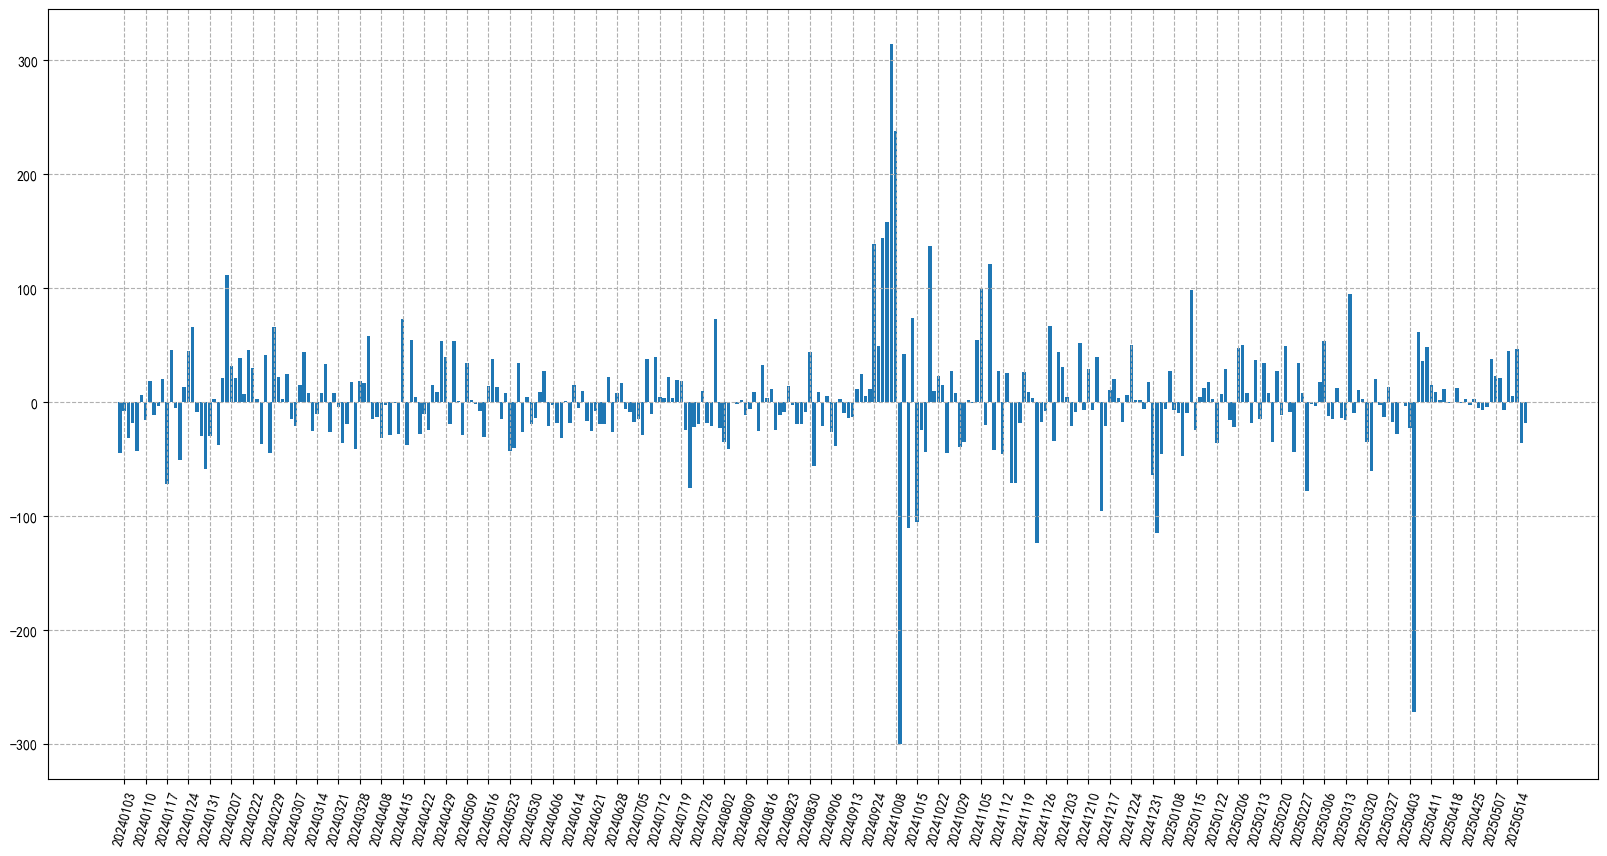

In [291]:
plt.figure(figsize=(20,10))
plt.grid(ls='--')
plt.xticks(range(1, len(data.index), 5), rotation=75)
plt.bar(data.index, data['slope'])

In [293]:
data['direction'] = data['slope'].apply(lambda x: 1 if x > 0 else -1)

In [303]:
data['turning_point'] = data['direction'].diff()

In [309]:
turning_point = data[data['turning_point'] != 0]

<BarContainer object of 167 artists>

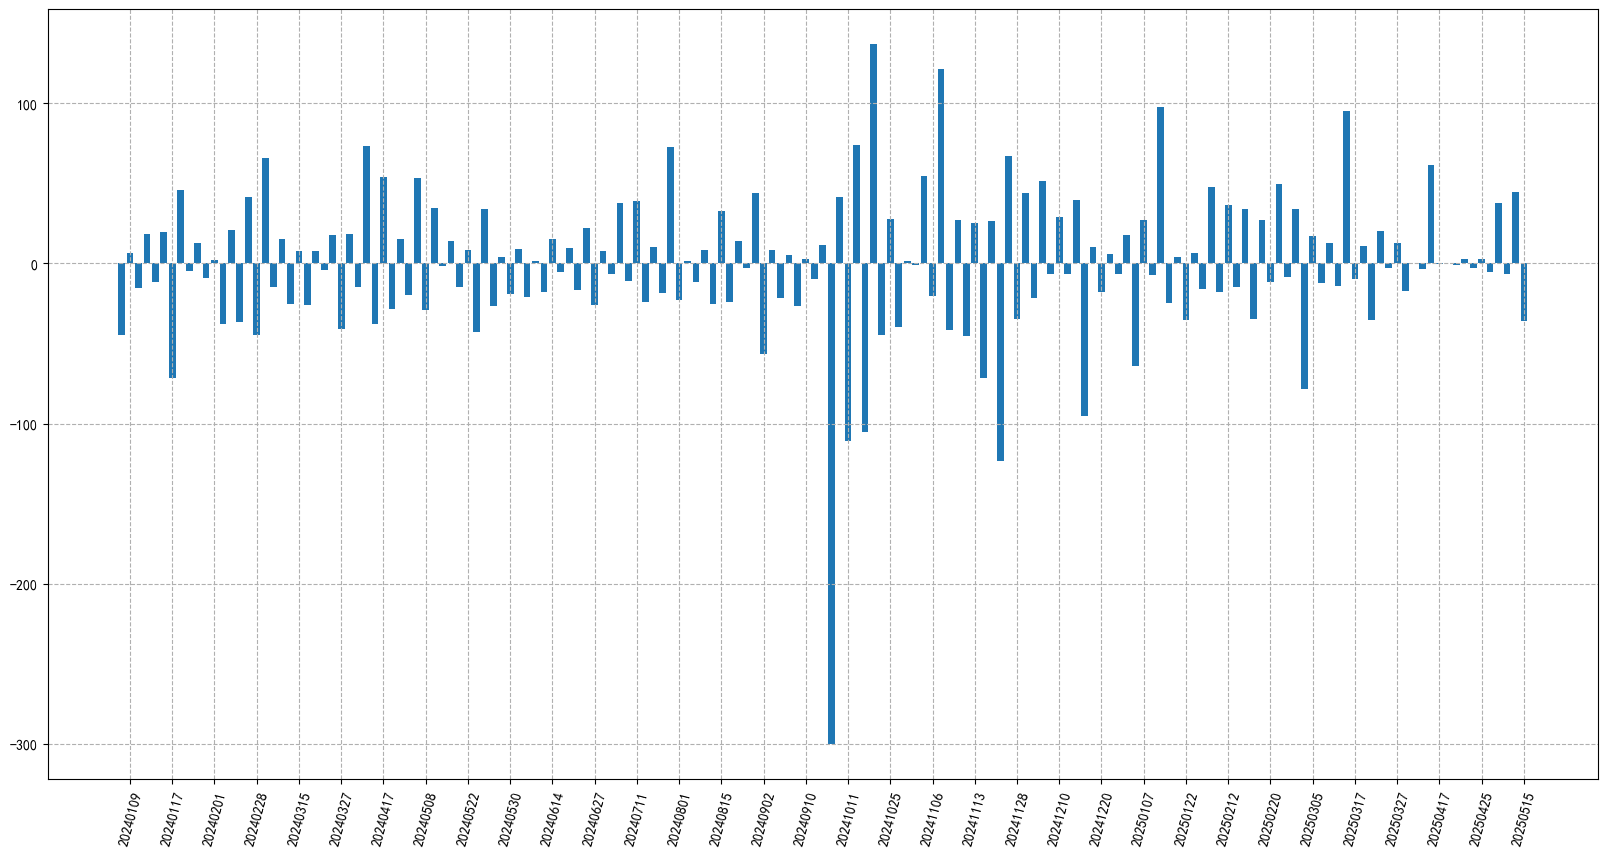

In [311]:
plt.figure(figsize=(20,10))
plt.grid(ls='--')
plt.xticks(range(1, len(turning_point.index), 5), rotation=75)
plt.bar(turning_point.index, turning_point['slope'])

In [317]:
turning_point[abs(turning_point['slope'] > 100)]

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,ma5,volume_ma5,daily_return,slope,direction,turning_point
20241018,1729180800000,3780.315,3998.214,3765.162,3925.234,312958834,6.206737e+11,0.0,0,3788.222,0,258840900.4,1.209078,1.036168,137.012,1,2.0
20241107,1730908800000,3987.266,4146.151,3984.665,4145.695,341436414,6.581459e+11,0.0,0,4024.283,0,306266537.4,1.114834,1.030170,121.412,1,2.0


<Axes: >

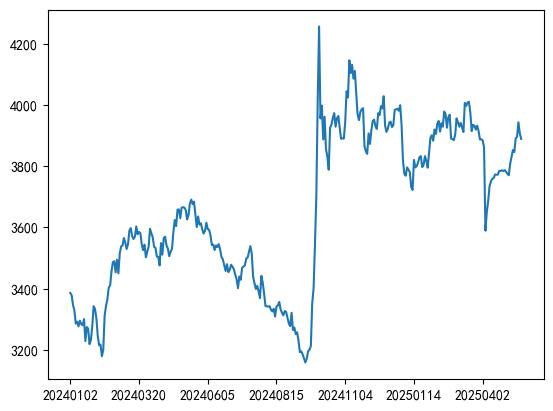

In [319]:
data['close'].plot()

<Axes: >

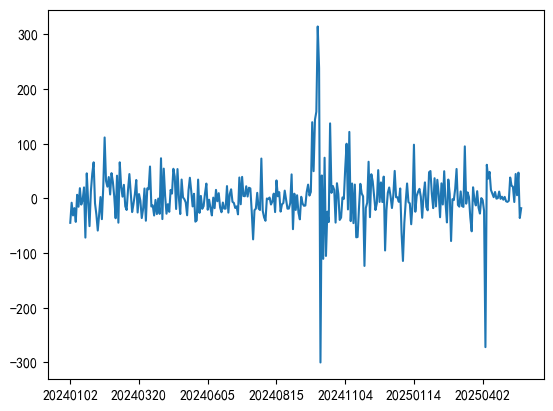

In [323]:
data['slope'].plot()

In [426]:
data['cum5_direction'] = data['direction'].rolling(window=6).sum() - data['direction']
data['cum30_direction'] = data['direction'].rolling(window=31).sum() - data['direction']
data['diff5'] = data['close'].diff(5)
data['diff10'] = data['close'].diff(10)
data['diff30'] = data['close'].diff(30)

<Axes: >

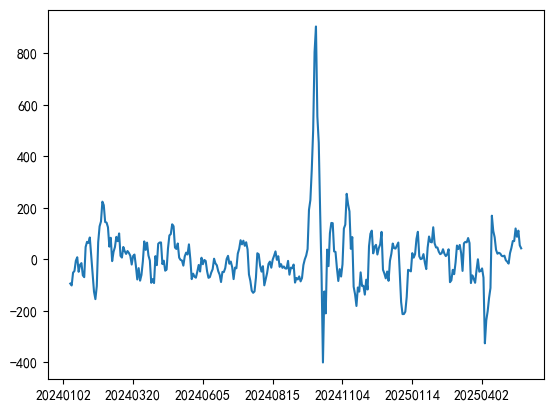

In [412]:
data['diff5'].plot()

In [343]:
data[['direction', 'cum_direction']].tail(30)

,direction,cum_direction
20250401,1,-3.0
20250402,-1,-1.0
20250403,-1,-1.0
20250407,-1,-3.0
20250408,1,-3.0
20250409,1,-1.0
20250410,1,-1.0
20250411,1,1.0
20250414,1,3.0
20250415,1,5.0


In [355]:
data[['cum5_direction', 'cum30_direction']].value_counts()

cum5_direction  cum30_direction
-1.0             2.0               24
 1.0             0.0               18
                 2.0               17
-1.0            -2.0               14
                -4.0               13
-3.0            -4.0               10
-1.0             0.0               10
-3.0             0.0               10
 1.0             8.0                9
                -2.0                9
-1.0            -6.0                9
 3.0             0.0                9
                 2.0                9
-3.0            -6.0                8
-1.0             4.0                8
 1.0             4.0                7
-1.0            -10.0               7
 1.0             6.0                6
 3.0             8.0                6
-3.0            -10.0               6
 1.0            -4.0                6
                 10.0               5
 3.0             6.0                5
 5.0             2.0                5
-3.0            -8.0                4
 5.0             0

In [377]:
data['cum30_direction'].value_counts()
data[data['cum30_direction'] >= 8]

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,ma5,volume_ma5,daily_return,slope,direction,turning_point,cum_direction,cum5_direction,cum30_direction
20240305,1709568000000,3524.965,3570.694,3519.082,3565.515,166422389,2.998959e+11,0.0,0,3540.869,0,167631730.4,0.992786,1.006960,24.646,1,0.0,3.0,3.0,8.0
20240306,1709654400000,3556.532,3577.388,3545.101,3551.048,143076613,2.482942e+11,0.0,0,3565.514,0,158279543.4,0.903949,0.995943,-14.466,-1,-2.0,3.0,3.0,10.0
20240307,1709740800000,3548.100,3569.918,3522.896,3529.719,148110510,2.518395e+11,0.0,0,3551.048,0,156712739.0,0.945108,0.993994,-21.329,-1,0.0,3.0,3.0,8.0
20240308,1709827200000,3529.551,3548.505,3511.577,3544.910,125792664,2.253791e+11,0.0,0,3529.719,0,149329357.8,0.842384,1.004304,15.191,1,2.0,1.0,1.0,8.0
20240311,1710086400000,3545.943,3589.264,3542.279,3589.264,148202825,2.864186e+11,0.0,0,3544.910,0,146321000.2,1.012861,1.012512,44.354,1,0.0,1.0,1.0,8.0
20240312,1710172800000,3592.583,3605.698,3574.212,3597.494,180685560,3.399970e+11,0.0,0,3589.264,0,149173634.4,1.211243,1.002293,8.230,1,0.0,1.0,1.0,10.0
20240313,1710259200000,3594.422,3594.422,3563.369,3572.361,144590590,2.668988e+11,0.0,0,3597.494,0,149476429.8,0.967314,0.993014,-25.133,-1,-2.0,1.0,1.0,12.0
20240314,1710345600000,3571.789,3597.460,3545.612,3562.223,140962722,2.638036e+11,0.0,0,3572.361,0,148046872.2,0.952149,0.997162,-10.138,-1,0.0,1.0,1.0,10.0
20240315,1710432000000,3554.907,3572.809,3533.680,3569.993,138316044,2.439916e+11,0.0,0,3562.223,0,150551548.2,0.918729,1.002181,7.770,1,2.0,1.0,1.0,8.0
20240318,1710691200000,3577.056,3604.052,3573.404,3603.528,160379438,2.953148e+11,0.0,0,3569.993,0,152986870.8,1.048322,1.009394,33.535,1,0.0,1.0,1.0,8.0


In [444]:
data[(data['cum5_direction'] * data['cum30_direction'] >= 0) & (abs(data['cum30_direction']) >= 8) & (abs(data['slope']) > 20) & (data['turning_point'] != 0)][
['close', 'volume', 'preClose', 'daily_return', 'slope', 'direction', 'turning_point', 'cum5_direction', 'cum30_direction','diff5','diff10','diff30']]
#data[(data['cum5_direction'] * data['cum30_direction'] >= 0) & (abs(data['cum30_direction']) >= 8)]['slope'].plot()
#[['cum5_direction', 'cum30_direction']].value_counts()

,close,volume,preClose,daily_return,slope,direction,turning_point,cum5_direction,cum30_direction,diff5,diff10,diff30
20240313,3572.361,144590590,3597.494,0.993014,-25.133,-1,-2.0,1.0,12.0,21.313,122.101,340.428
20240319,3577.630,145571786,3603.528,0.992813,-25.898,-1,-2.0,1.0,10.0,-19.864,12.115,273.670
20240626,3480.265,105898861,3457.902,1.006467,22.363,1,2.0,-5.0,-8.0,-48.484,-63.858,-176.780
20240709,3439.812,131629443,3401.761,1.011186,38.051,1,2.0,-5.0,-10.0,-31.974,-18.090,-195.896
20240711,3468.169,145892466,3428.966,1.011433,39.203,1,2.0,-3.0,-10.0,22.356,14.051,-145.353
20240830,3321.433,188695443,3277.682,1.013348,43.751,1,2.0,-3.0,-12.0,-5.757,-24.201,-217.582
20240902,3265.012,147612353,3321.433,0.983013,-56.421,-1,-2.0,-3.0,-12.0,-59.211,-91.956,-249.913
20240904,3252.165,104832482,3273.428,0.993504,-21.263,-1,-2.0,-1.0,-10.0,-34.331,-69.470,-166.001
20241024,3928.834,174724062,3973.209,0.988831,-44.375,-1,-2.0,3.0,8.0,140.612,-68.954,655.405
20241029,3924.649,217293984,3964.157,0.990034,-39.508,-1,-2.0,3.0,8.0,-33.127,68.654,693.303


In [452]:
data.loc['20250107']

time                1.736179e+12
open                3.760866e+03
high                3.797602e+03
low                 3.749058e+03
close               3.796105e+03
volume              1.464558e+08
amount              2.668558e+11
settelementPrice    0.000000e+00
openInterest        0.000000e+00
preClose            3.768970e+03
suspendFlag         0.000000e+00
ma5                 1.749144e+08
volume_ma5          8.372995e-01
daily_return        1.007200e+00
slope               2.713500e+01
direction           1.000000e+00
turning_point       2.000000e+00
cum_direction      -3.000000e+00
cum5_direction     -3.000000e+00
cum30_direction     0.000000e+00
diff5              -2.029490e+02
diff10             -1.374670e+02
diff30             -5.198600e+01
Name: 20250107, dtype: float64

In [454]:
data.tail(5)

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,...,daily_return,slope,direction,turning_point,cum_direction,cum5_direction,cum30_direction,diff5,diff10,diff30
20250512,1746979200000,3866.531,3890.735,3859.035,3890.610,153332460,2.961229e+11,0.0,0,3846.157,...,1.011558,44.453,1,2.0,1.0,1.0,2.0,120.040,103.728,-41.685
20250513,1747065600000,3915.593,3915.593,3890.686,3896.259,147320299,2.675864e+11,0.0,0,3890.610,...,1.001452,5.649,1,0.0,3.0,3.0,4.0,87.717,111.902,-23.098
20250514,1747152000000,3894.838,3960.522,3890.650,3943.210,172033779,3.194652e+11,0.0,0,3896.258,...,1.012051,46.952,1,0.0,3.0,3.0,6.0,111.583,156.217,10.798
20250515,1747238400000,3934.027,3936.466,3904.907,3907.199,138081749,2.414649e+11,0.0,0,3943.211,...,0.990867,-36.012,-1,-2.0,3.0,3.0,6.0,54.303,125.580,-7.967
20250516,1747324800000,3898.666,3903.853,3874.862,3889.086,118405345,2.088357e+11,0.0,0,3907.199,...,0.995364,-18.113,-1,0.0,1.0,1.0,6.0,42.929,114.009,1.780


# 机器学习

In [400]:
#标注数据
#加工因子

In [548]:
data.describe()

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,idx
count,4.945000e+03,4945.000000,4945.000000,4945.000000,4945.000000,4.945000e+03,4.945000e+03,4945.0,4945.0,4945.000000,4945.0,4945.000000
mean,1.425922e+12,3253.204606,3282.837793,3223.461968,3255.772847,1.040370e+08,1.492424e+11,0.0,0.0,3255.188136,0.0,-0.003438
std,1.853000e+11,1072.219870,1080.258019,1061.498485,1071.696135,7.877474e+07,1.291681e+11,0.0,0.0,1072.138190,0.0,0.345141
min,1.104768e+12,816.546000,823.860000,807.784000,818.033000,5.014525e+06,2.901827e+09,0.0,0.0,818.033000,0.0,-1.000000
25%,1.265040e+12,2526.968000,2553.058000,2504.458000,2529.231000,5.338916e+07,5.956344e+10,0.0,0.0,2528.236000,0.0,0.000000
50%,1.426435e+12,3361.781000,3390.551000,3335.599000,3364.450000,8.840042e+07,1.126419e+11,0.0,0.0,3364.080000,0.0,0.000000
75%,1.586275e+12,3916.114000,3944.762000,3886.554000,3916.583000,1.319873e+08,2.081362e+11,0.0,0.0,3916.583000,0.0,0.000000
max,1.747325e+12,5922.071000,5930.912000,5815.609000,5877.202000,6.864391e+08,1.130387e+12,0.0,0.0,5877.202000,0.0,1.000000


In [550]:
data[data['idx'] != 0]

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,idx
20050111,1105372800000,994.190,999.550,991.090,997.140,5849080,3.704080e+09,0.0,0,993.880,0,1.0
20050120,1106150400000,963.210,963.210,952.230,956.250,7727106,4.399350e+09,0.0,0,967.210,0,-1.0
20050124,1106496000000,1001.850,1001.850,986.240,998.130,14359462,8.360160e+09,0.0,0,982.600,0,1.0
20050131,1107100800000,965.790,965.790,953.140,954.880,6788706,3.863570e+09,0.0,0,969.210,0,-1.0
20050225,1109260800000,1046.270,1059.480,1045.980,1046.760,18170004,1.148996e+10,0.0,0,1045.460,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
20250319,1742313600000,4004.825,4025.299,3989.512,4010.168,144419428,2.860753e+11,0.0,0,4007.723,0,1.0
20250321,1742486400000,3966.514,3983.147,3904.767,3914.695,165905294,3.093486e+11,0.0,0,3974.991,0,-1.0
20250407,1743955200000,3675.202,3707.778,3514.117,3589.441,312578586,5.129718e+11,0.0,0,3861.504,0,-1.0
20250430,1745942400000,3775.830,3787.564,3768.757,3770.570,143681658,2.448205e+11,0.0,0,3775.076,0,-1.0


In [ ]:
max_idx = argrelextrema(data['close'].values, np.greater, order=5)[0]

In [566]:
data.shape

(4945, 12)

In [568]:
test = data[data.index <= '20250515']
test.tail()

,time,open,high,low,close,volume,amount,settelementPrice,openInterest,preClose,suspendFlag,idx
20250509,1746720000000,3848.619,3853.663,3836.535,3846.157,119389526,2.166979e+11,0.0,0,3852.896,0,0.0
20250512,1746979200000,3866.531,3890.735,3859.035,3890.610,153332460,2.961229e+11,0.0,0,3846.157,0,0.0
20250513,1747065600000,3915.593,3915.593,3890.686,3896.259,147320299,2.675864e+11,0.0,0,3890.610,0,0.0
20250514,1747152000000,3894.838,3960.522,3890.650,3943.210,172033779,3.194652e+11,0.0,0,3896.258,0,1.0
20250515,1747238400000,3934.027,3936.466,3904.907,3907.199,138081749,2.414649e+11,0.0,0,3943.211,0,0.0


In [570]:
max_idx = argrelextrema(test['close'].values, np.greater, order=5)[0]
max_idx

array([   5,   14,   31,   38,   61,  100,  112,  123,  147,  172,  184,
        192,  199,  216,  258,  265,  275,  328,  338,  358,  365,  374,
        416,  424,  500,  515,  576,  591,  645,  671,  682,  711,  733,
        748,  754,  763,  788,  805,  812,  842,  851,  862,  881,  907,
        938,  955,  962,  972,  996, 1009, 1040, 1060, 1112, 1127, 1145,
       1166, 1186, 1196, 1214, 1237, 1252, 1274, 1281, 1308, 1320, 1326,
       1368, 1381, 1407, 1417, 1430, 1443, 1457, 1486, 1498, 1510, 1521,
       1559, 1578, 1586, 1607, 1615, 1633, 1646, 1660, 1738, 1745, 1779,
       1795, 1809, 1822, 1846, 1868, 1885, 1893, 1902, 1967, 1978, 1994,
       2012, 2022, 2036, 2065, 2088, 2110, 2125, 2150, 2162, 2181, 2198,
       2209, 2234, 2246, 2266, 2278, 2290, 2306, 2325, 2336, 2349, 2367,
       2391, 2409, 2429, 2436, 2442, 2462, 2501, 2511, 2521, 2530, 2554,
       2562, 2574, 2594, 2603, 2623, 2632, 2644, 2663, 2682, 2701, 2712,
       2721, 2731, 2738, 2752, 2759, 2773, 2799, 28

In [572]:
test.index[max_idx]

Index(['20050111', '20050124', '20050225', '20050308', '20050408', '20050609',
       '20050627', '20050712', '20050815', '20050919',
       ...
       '20240731', '20240819', '20241008', '20241023', '20241107', '20241212',
       '20241230', '20250221', '20250319', '20250514'],
      dtype='object', length=286)

In [ ]:
%matplotlib inline
import backtrader as bt
from datetime import datetime
import backtrader.indicators as btin
import backtrader.talib as btta

class MyStrategy(bt.Strategy):
    # 设置自定义策略的params参数。
    params = (('short', 15), ('long', 60))

    # 定义初始化函数。
    def __init__(self,a,b):
        self.start_cash = self.broker.getcash()
        print("回测框架开始运行，初始资金：",self.broker.getcash())
        # 调用backtrader自带指标SMA。
        self.bt_sma = btin.SMA(self.data, period=self.p.short)
        # 调用talib指标SMA。
        self.talib_sma = btta.SMA(self.data, timeperiod=self.p.long)
        # 计算当前收盘价与前一日收盘价差数据序列
        # 引入数据中整列数据序列与整列数据前一日数据序列的示例。
        self.dif = self.data0.close-self.data0.close(-1)

    # 定义next函数。
    def next(self):
        # 买入条件：①空仓；②短周期均线在长周期上方。
        if not self.position:
            if data
                self.buy()
        # 卖出条件：①非空仓；②短周期均线在长周期下方。
        if self.position:
            if self.bt_sma[0] < self.talib_sma[0]:
                # 执行卖出操作。
                self.sell()

# 创建Cerebro引擎对象。
cerebro = bt.Cerebro()
# 将数据添加到Cerebro引擎中。
#data = bt.feeds.GenericCSVData(
#    dataname='sh600000.csv',
#    dtformat=('%Y-%m-%d'),
#    fromdate=datetime(2014, 1, 1),
#    todate=datetime(2014, 12, 31))
cerebro.adddata(data)
# 将策略添加到Cerebro引擎中。
# my_strategy = MyStrategy(1,2)
cerebro.addstrategy(MyStrategy,a=1,b=2)
# 设置初始资金为100000元。
cerebro.broker.setcash(100000)
# 调取回测设置初始资金存储至start_cash变量。
start_cash = cerebro.broker.getcash()
# 设置每次交易的股票数量为1000股。
cerebro.addsizer(bt.sizers.FixedSize, stake=1000)
cerebro.addanalyzer(bt.analyzers.Returns)
# 运行回测。
results = cerebro.run()
# 打印执行策略最终资产价值。
print('策略终值：%.2f' % cerebro.broker.getvalue())
# 调用回测结果中analyzer.returns的收益率值。
returns_bt = results[0].analyzers.returns.get_analysis()['rtot']
print(f'backtrader计算的收益率：{returns_bt:.2%}')

# 手工计算回测后的收益率。
final_portfolio_value = cerebro.broker.getvalue()
initial_portfolio_value = start_cash
returns_my = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value
print(f'手工计算的收益率：{returns_my:.2%}')
# 回测结果可视化输出（不显示成交量）。
#cerebro.plot(volume=False)
cerebro.plot(style='line',iplot=False)